In [89]:
!source ../setup.sh

import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from utils.metrics import regression_report

In [109]:
import numpy as np
import pandas as pd
import joblib
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tensorflow as tf
import random
from sklearn.metrics import mean_absolute_error
from keras import Sequential
from keras import layers
from keras.models import Model
from keras.layers import LSTM, Dropout, Dense, Flatten, Conv1D
from keras.layers import Input,Masking, dot
from keras.optimizers import Adam


In [91]:
# convert series to supervised learning 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True): 
    n_vars = 1 if type(data) is list else data.shape[1] 
    df = pd.DataFrame(data) 
    cols, names = list(), list() 
    # input sequence (t-n, ... t-1) 
    for i in range(n_in, 0, -1):  
        cols.append(df.shift(i))  
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)] 
    # forecast sequence (t, t+1, ... t+n) 
    for i in range(0, n_out):  
        cols.append(df.shift(-i))  
        if i == 0:   
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]  
        else:   
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)] 
    # put it all together 
    agg = pd.concat(cols, axis=1) 
    agg.columns = names 
    # drop rows with NaN values 
    if dropnan:  
        agg.dropna(inplace=True) 
    return agg 

In [92]:
# Load the data (created during baseline)
train = pd.read_csv("./tmp_lstm/train.csv")
valid = pd.read_csv("./tmp_lstm/valid.csv")
test = pd.read_csv("./tmp_lstm/test.csv")
df_initial = pd.concat([train, valid,test], ignore_index=True)

def move_column_to_end(df, col_name):
    col = df.pop(col_name)
    df[col_name] = col
    return df

# Assuming your DataFrame is df_initial and you want to move 'measured_t_mean' to the end
df_initial= move_column_to_end(df_initial, 'measured_t_mean')

In [93]:
df_initial

classroom_type  school_day  school_hours  break_time  power_on  \
0                   0           1             0           0         1   
1                   1           1             0           0         1   
2                   2           1             0           0         1   
3                   4           1             0           0         1   
4                   0           1             1           0         1   
...               ...         ...           ...         ...       ...   
28021               1           1             0           0         1   
28022               2           1             0           0         1   
28023               3           1             0           0         1   
28024               4           1             0           0         1   
28025               5           1             0           0         1   

       trackerwm_avg_mean  shadowwm_avg_mean  sunwm_avg_mean  \
0                0.011026           0.120501        0.020462   
1                0.011313           0.145285        0.024634   
2                0.033126           0.180489        0.032191   
3                0.001889           0.152176        0.025020   
4                0.464367           0.192743        0.090702   
...                   ...                ...             ...   
28021            0.000000           0.000000        0.000000   
28022            0.000000           0.000000        0.000000   
28023            0.000000           0.000000        0.000000   
28024            0.000000           0.000000        0.000000   
28025            0.000000           0.000000        0.000000   

       shadowbandwm_avg_mean  dnicalc_avg_mean  ...  ws_ms_s_wvt_mean  \
0                   0.045077          0.017824  ...          0.028474   
1                   0.054065          0.012926  ...          0.020416   
2                   0.066739          0.021338  ...          0.071458   
3                   0.056610          0.008966  ...          0.042610   
4                   0.071083          0.243491  ...          0.015844   
...                      ...               ...  ...               ...   
28021               0.000000          0.006729  ...          0.170665   
28022               0.000000          0.006729  ...          0.148995   
28023               0.000000          0.006729  ...          0.120082   
28024               0.000000          0.006729  ...          0.155466   
28025               0.000000          0.006729  ...          0.147812   

       winddir_d1_wvt_mean  winddir_sd1_wvt_mean  bp_mb_avg_mean  \
0                 0.022461              0.032420        0.099109   
1                 0.014059              0.032387        0.099379   
2                 0.049206              0.113354        0.100912   
3                 0.017301              0.060713        0.099583   
4                 0.110935              0.054132        0.107573   
...                    ...                   ...             ...   
28021             0.926029              0.190350        0.344571   
28022             0.647137              0.265332        0.344912   
28023             0.694615              0.269847        0.345198   
28024             0.762325              0.239352        0.344908   
28025             0.688370              0.271442        0.344721   

       uva_avg_mean  uvb_avg_mean  Month  Day  Hour  measured_t_mean  
0          0.008539      0.093667      3   16     7         0.647059  
1          0.008752      0.093545      3   16     7         0.638739  
2          0.008796      0.093511      3   16     7         0.679674  
3          0.009259      0.093511      3   16     7         0.578334  
4          0.008796      0.093511      3   16     8         0.690157  
...             ...           ...    ...  ...   ...              ...  
28021      0.296409      0.799597     11    6    23         0.714230  
28022      0.296417      0.804018     11    6    23         0.675544  
28023      0.296419      0.8

In [94]:
# specify no. of lag hours
n_hours = 6
n_features = 21

# frame as supervised learning
reframed = series_to_supervised(df_initial,n_hours,1)
print(reframed.shape)


(28020, 154)


In [95]:
total_rows = len(reframed)
n_train = int(total_rows * 0.7)
n_val = int(total_rows * 0.1)
n_test = total_rows - n_train - n_val

train = reframed.values[:n_train, :]
val = reframed.values[n_train:n_train + n_val, :]
test = reframed.values[n_train + n_val:, :]

# Number of observations (features) excluding the last one (output variable)
n_obs = n_hours * n_features

# Divide into inputs and outputs
X_train, y_train = train[:, :n_obs], train[:, -1] 
X_val, y_val  = val[:, :n_obs], val[:, -1]  
X_test, y_test  = test[:, :n_obs], test[:, -1] 

# Reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], n_hours, n_features))
X_val = X_val.reshape((X_val.shape[0], n_hours, n_features))
X_test = X_test.reshape((X_test.shape[0], n_hours, n_features))

y_train=y_train.reshape(-1,1)
y_val=y_val.reshape(-1,1)
y_test=y_test.reshape(-1,1)


In [96]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [98]:
scaler_y =joblib.load("./tmp_lstm/assets/min_max_scaler_y.joblib",mmap_mode=None)

In [99]:
def plot_results(y_pred_actual, y_test_inv, history, model_name):
    fig, ax = plt.subplots(2, 1, figsize=(12, 6))
    
    ax[0].plot(y_pred_actual[:168])
    ax[0].plot(y_test_inv[:168])
    ax[0].legend(['prediction', 'actual'], loc='upper left')
    ax[0].set_title(f'Prediction vs Actual Temperature ({model_name})')
    ax[0].set_xlabel('Observation')
    ax[0].set_ylabel('Indoor Temperature')


    ax[1].plot(history.history['loss'], label='Training Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')

    ax[1].legend()
    ax[1].set_title(f'Training and validation MAE ({model_name})')
    ax[1].set_xlabel('Iteration/Epochs')
    ax[1].set_ylabel('MAE')    
        
    fig.tight_layout()
    plt.show()

In [105]:
# Set random seeds for reproducibility
seed = 3
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [124]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

scaler =joblib.load("./tmp_lstm/assets/min_max_scaler_y.joblib",mmap_mode=None)


def lstm_model(X_train, y_train, X_val, y_val, EPOCH,BATCH_SIZE,CALLBACK,  plotting=False):
    
    class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if (logs.get("val_mae")<CALLBACK):
                print("\n Accuracy % so cancelling training")
                self.model.stop_training=True

    callbacks = myCallback()
    

    model = Sequential()
    model.add(LSTM(units=16, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=True, activation='relu', name='LSTM_1'))
    model.add(Dropout(0.1))
    model.add(LSTM(units=32, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=False, activation='relu', name='LSTM_2'))
    model.add(Dropout(0.1))
    model.add(Dense(1, name='Output')) 

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 0.228 * 10**(epoch / 20))
    # optimizer = tf.keras.optimizers.SGD(learning_rate=0.228, momentum =.85)
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])#loss='Huber',optimizer=optimizer, metrics=['mae']
    history = model.fit(X_train, y_train,batch_size=BATCH_SIZE, epochs=EPOCH,callbacks=[callbacks],  validation_data=[X_val, y_val], verbose=1)
    
    model.save("lstm_model.h5")
    
    if plotting == True:
        plt.figure(figsize=(18, 6))

        lrs = 1e-5 * (10 ** (np.arange(len(history.history["loss"])) / 20))
        plt.semilogx(lrs, history.history["loss"])
        plt.xticks(size=14)
        plt.show()

        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        y_test_inv = scaler_y.inverse_transform(y_test)

        results = []

        print('---------------------------------------------------')
        print(f'LSTM evaluation for train set:')
        train_report = regression_report(y_train, y_train_pred)
        print(train_report)
        print(f'LSTM evaluation for test set:')
        test_report = regression_report(y_pred,y_test)
        print(test_report)
        print('---------------------------------------------------')
        y_pred_actual = scaler_y.inverse_transform(y_pred)
        print('')
        plot_results(y_pred_actual, y_test_inv, history,'LSTM')

        results.append([
                train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
                test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
            ])

        print(results)

    return model

Epoch 1/50


/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


654/654 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0233 - mae: 0.1455 - val_loss: 0.0041 - val_mae: 0.0742
Epoch 2/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0048 - mae: 0.0763 - val_loss: 0.0022 - val_mae: 0.0512
Epoch 3/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0035 - mae: 0.0652 - val_loss: 0.0014 - val_mae: 0.0411
Epoch 4/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0028 - mae: 0.0588 - val_loss: 0.0018 - val_mae: 0.0488
Epoch 5/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0026 - mae: 0.0561 - val_loss: 0.0018 - val_mae: 0.0482
Epoch 6/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0024 - mae: 0.0531 - val_loss: 0.0023 - val_mae: 0.0555
Epoch 7/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0022 - mae: 0.0512 - val_loss: 0.0019 - val_mae: 0.0492
Epoch 8/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0021 - mae: 0.0496 - val_loss: 0.0022 - val_mae: 0.0531
Epoch 9/50
654/654 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0019 

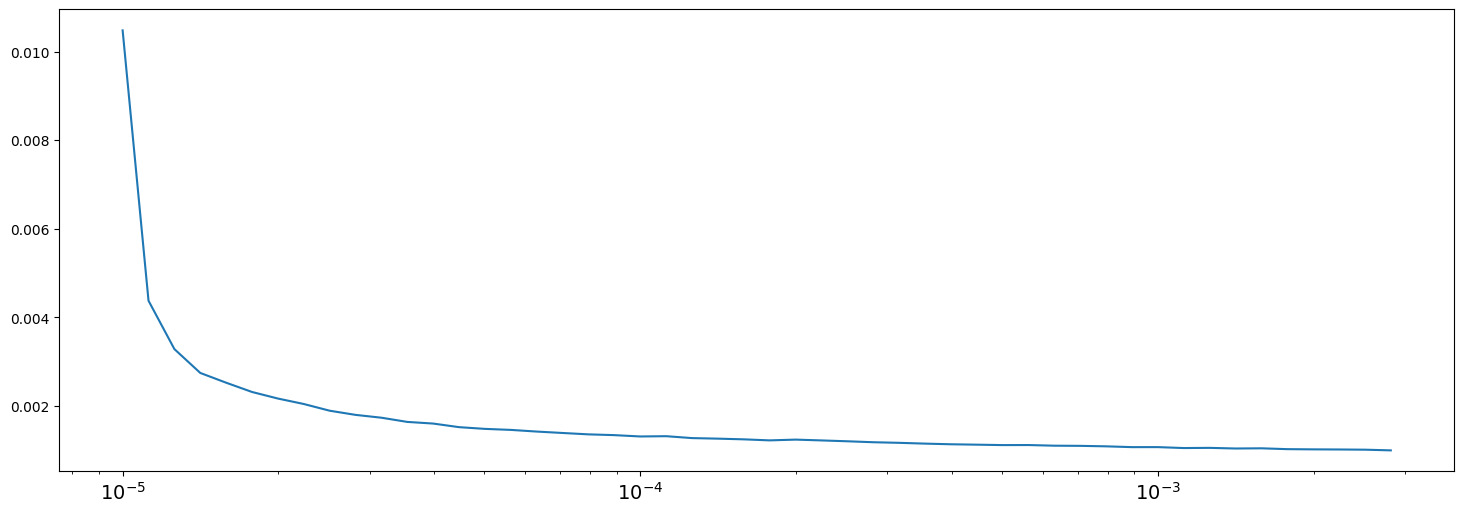

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step
---------------------------------------------------
LSTM evaluation for train set:
{'Mean Absolute Error (MAE)': 0.03096118888828197, 'Mean Squared Error (MSE)': 0.0017793283649655488, 'Root Mean Squared Error (RMSE)': 0.04218208582995332, 'Mean Absolute Percentage Error (MAPE)': 20527025565.045063, 'R2 Score': 0.8847652545520501}
LSTM evaluation for test set:
{'Mean Absolute Error (MAE)': 0.06597049090306549, 'Mean Squared Error (MSE)': 0.007029405374325925, 'Root Mean Squared Error (RMSE)': 0.08384154921234414, 'Mean Absolute Percentage Error (MAPE)': 0.11993169389939079, 'R2 Score': 0.4651744168521482}
---------------------------------------------------



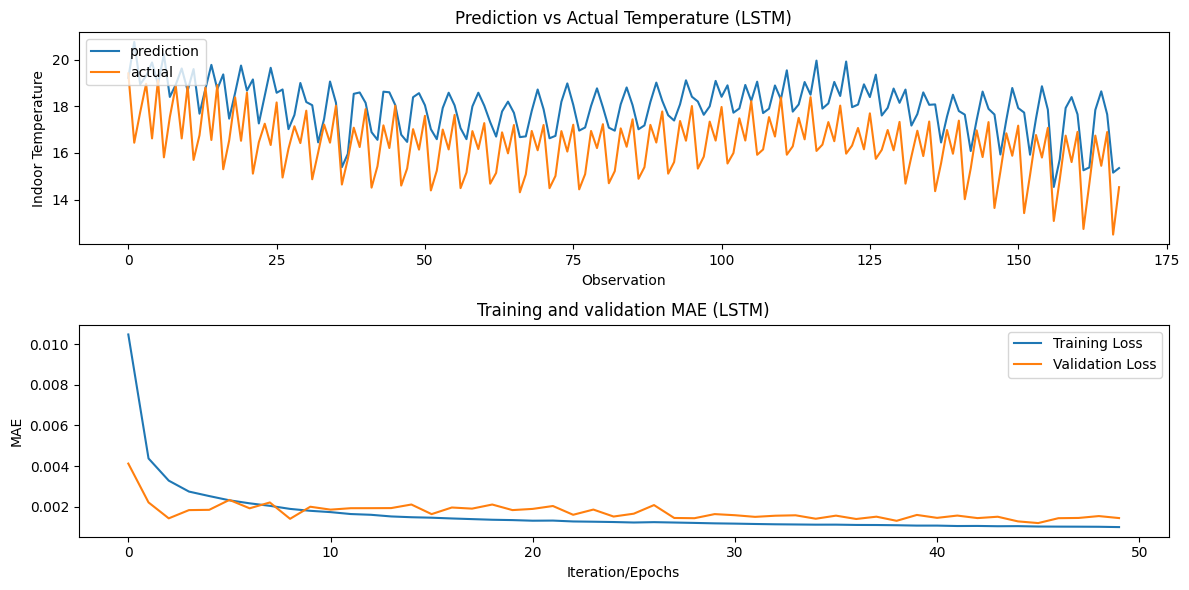

[[0.8847652545520501, 0.03096118888828197, 0.04218208582995332, 20527025565.045063, 0.4651744168521482, 0.06597049090306549, 0.08384154921234414, 0.11993169389939079]]


In [126]:
CALLBACK = .031 #Used to stop training the Network when the MAE from the validation set reached a perormance below 3.1%
BATCH_SIZE = 30 #Number of samples that will be propagated through the network. I chose almost a trading month
EPOCH = 50 #Settled to train the model
model_lstm = lstm_model(X_train, y_train, X_val, y_val, EPOCH, BATCH_SIZE, CALLBACK, plotting=True)

21
21
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 468us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step


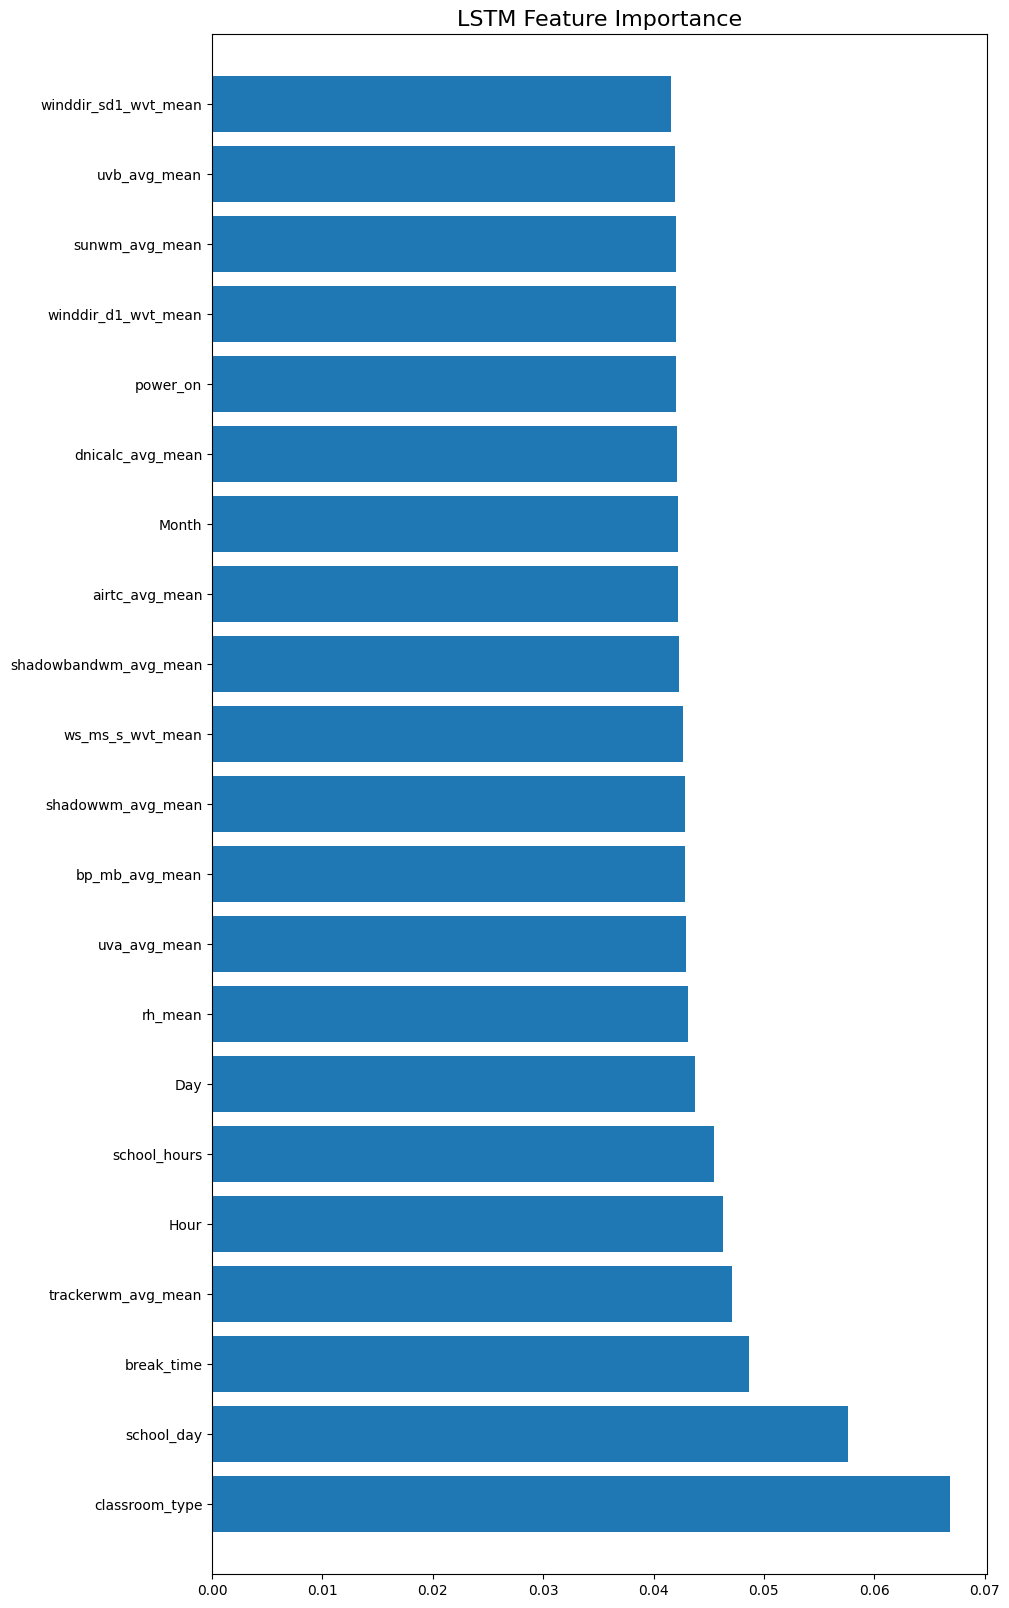

In [127]:
# Compute feature importance
def compute_feature_importance(model, X_valid, y_valid, feature_names):
    results = []
    base_mae = mean_absolute_error(y_valid, model.predict(X_valid).squeeze())
    
    for i in range(X_valid.shape[2]):
        save_col = X_valid[:, :, i].copy()
        np.random.shuffle(X_valid[:, :, i])
        mae = mean_absolute_error(y_valid, model.predict(X_valid).squeeze())
        results.append({'feature': feature_names[i], 'mae': mae})
        X_valid[:, :, i] = save_col
    
    return results

# Feature names from the DataFrame columns
feature_names = ['classroom_type', 'school_day', 'school_hours', 'break_time', 'power_on', 'trackerwm_avg_mean', 'shadowwm_avg_mean',
                 'sunwm_avg_mean', 'shadowbandwm_avg_mean', 'dnicalc_avg_mean', 'airtc_avg_mean', 'rh_mean', 'ws_ms_s_wvt_mean',
                 'winddir_d1_wvt_mean', 'winddir_sd1_wvt_mean', 'bp_mb_avg_mean', 'uva_avg_mean', 'uvb_avg_mean', 'Month', 'Day', 'Hour']

print(X_train.shape[2])
print(len(feature_names))
# Ensure the number of features matches
assert X_train.shape[2] == len(feature_names), "Number of features in the data does not match the number of feature names."

# Compute feature importance
feature_importance = compute_feature_importance(model_lstm, X_val, y_val, feature_names)

# Display feature importance
df_importance = pd.DataFrame(feature_importance)
df_importance = df_importance.sort_values('mae', ascending=False)
plt.figure(figsize=(10, 20))
plt.barh(np.arange(len(df_importance)), df_importance.mae)
plt.yticks(np.arange(len(df_importance)), df_importance.feature.values)
plt.title('LSTM Feature Importance', size=16)
plt.ylim((-1, len(df_importance)))
plt.show()

# Save feature importance
df_importance.to_csv('lstm_feature_importance_3.csv', index=False)

# End of Code

The rest are additional experiments ran for hyperparamter tuning

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 6, 32)          │         6,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 6, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 6, 128)         │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,817 (542.25 KB)

 Trainable params: 138,817 (542.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
327/327 - 4s - 11ms/step - loss: 0.0085 - mae: 0.0942 - val_loss: 0.0211 - val_mae: 0.1814
Epoch 2/100
327/327 - 2s - 7ms/step - loss: 0.0058 - mae: 0.0824 - val_loss: 0.0137 - val_mae: 0.1430
Epoch 3/100
327/327 - 2s - 7ms/step - loss: 0.0050 - mae: 0.0755 - val_loss: 0.0139 - val_mae: 0.1448
Epoch 4/100
327/327 - 2s - 7ms/step - loss: 0.0047 - mae: 0.0730 - val_loss: 0.0137 - val_mae: 0.1438
Epoch 5/100
327/327 - 2s - 7ms/step - loss: 0.0045 - mae: 0.0711 - val_loss: 0.0134 - val_mae: 0.1426
Epoch 6/100
327/327 - 2s - 7ms/step - loss: 0.0043 - mae: 0.0697 - val_loss: 0.0131 - val_mae: 0.1408
Epoch 7/100
327/327 - 2s - 8ms/step - loss: 0.0041 - mae: 0.0681 - val_loss: 0.0129 - val_mae: 0.1391
Epoch 8/100
327/327 - 3s - 8ms/step - loss: 0.0040 - mae: 0.0673 - val_loss: 0.0120 - val_mae: 0.1336
Epoch 9/100
327/327 - 2s - 8ms/step - loss: 0.0038 - mae: 0.0659 - val_loss: 0.0117 - val_mae: 0.1308
Epoch 10/100
327/327 - 2s - 7ms/step - loss: 0.0037 - mae: 0.0648 - val_loss: 0.0

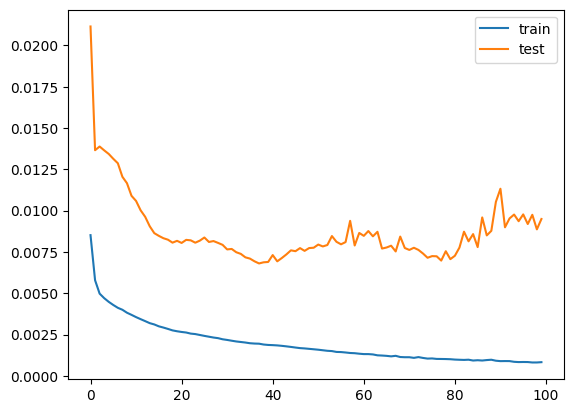

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
---------------------------------------------------
LSTM evaluation for train set:
{'Mean Absolute Error (MAE)': 0.04620468763482394, 'Mean Squared Error (MSE)': 0.003462376951377889, 'Root Mean Squared Error (RMSE)': 0.058841965903408504, 'Mean Absolute Percentage Error (MAPE)': 47134910044.17254, 'R2 Score': 0.7757658819514155}
LSTM evaluation for test set:
{'Mean Absolute Error (MAE)': 0.11715130979010847, 'Mean Squared Error (MSE)': 0.018990621306038596, 'Root Mean Squared Error (RMSE)': 0.13780646322302376, 'Mean Absolute Percentage Error (MAPE)': 0.2431469793964367, 'R2 Score': -1.071774963471546}
---------------------------------------------------



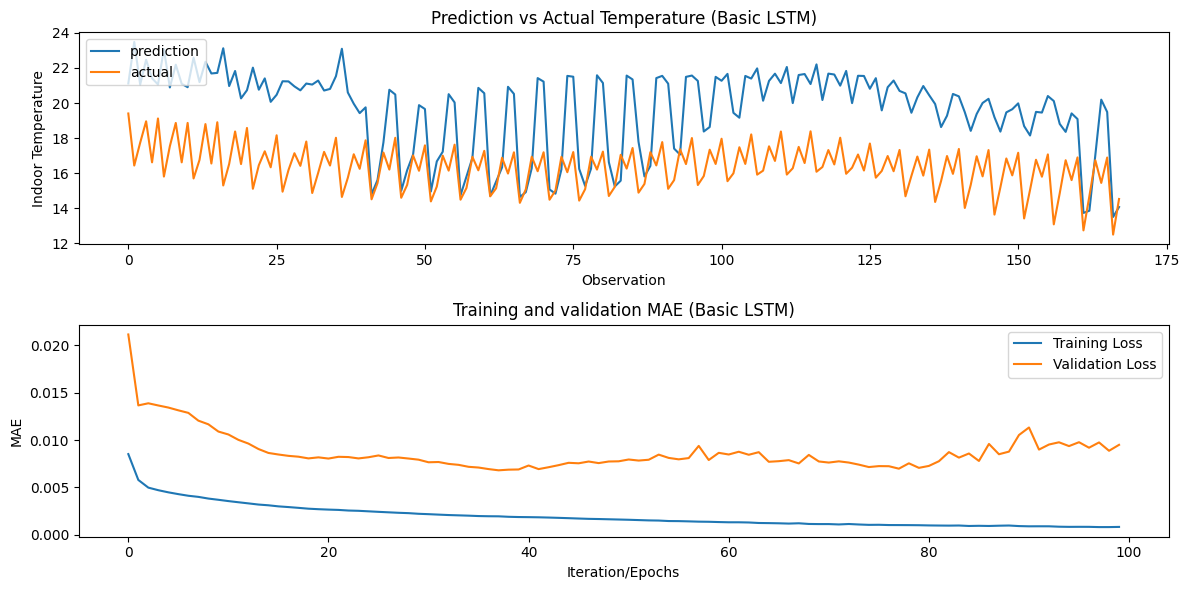

[[0.7757658819514155, 0.04620468763482394, 0.058841965903408504, 47134910044.17254, -1.071774963471546, 0.11715130979010847, 0.13780646322302376, 0.2431469793964367]]


In [43]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(32, input_shape= X_train.shape[-2:], return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
model.add(tf.keras.layers.Dropout(0.1)) 
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.1)) 
model.add(tf.keras.layers.Dense(1))


optimizer = Adam()
model.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

model.summary()

# fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=20,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'Basic LSTM')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 16)             │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,513 (9.82 KB)

 Trainable params: 2,513 (9.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
25/25 - 1s - 28ms/step - loss: 5.6894 - mae: 6.1754 - val_loss: 2.0661 - val_mae: 2.5520
Epoch 2/1000
25/25 - 0s - 3ms/step - loss: 1.0674 - mae: 1.4702 - val_loss: 0.3450 - val_mae: 0.7268
Epoch 3/1000
25/25 - 0s - 3ms/step - loss: 0.6598 - mae: 1.0334 - val_loss: 0.2055 - val_mae: 0.5493
Epoch 4/1000
25/25 - 0s - 3ms/step - loss: 0.3069 - mae: 0.6299 - val_loss: 0.1308 - val_mae: 0.4351
Epoch 5/1000
25/25 - 0s - 3ms/step - loss: 0.1846 - mae: 0.4624 - val_loss: 0.0872 - val_mae: 0.3499
Epoch 6/1000
25/25 - 0s - 3ms/step - loss: 0.1141 - mae: 0.3532 - val_loss: 0.0644 - val_mae: 0.2943
Epoch 7/1000
25/25 - 0s - 3ms/step - loss: 0.0763 - mae: 0.2835 - val_loss: 0.0490 - val_mae: 0.2517
Epoch 8/1000
25/25 - 0s - 3ms/step - loss: 0.0518 - mae: 0.2313 - val_loss: 0.0401 - val_mae: 0.2261
Epoch 9/1000
25/25 - 0s - 3ms/step - loss: 0.0377 - mae: 0.1995 - val_loss: 0.0344 - val_mae: 0.2125
Epoch 10/1000
25/25 - 0s - 4ms/step - loss: 0.0297 - mae: 0.1773 - val_loss: 0.0313 - val_

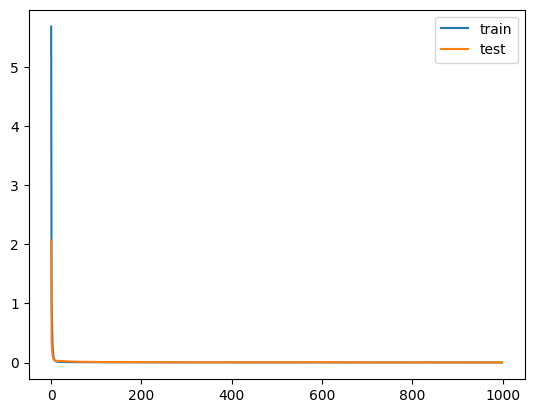

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
---------------------------------------------------
LSTM evaluation for train set:
{'Mean Absolute Error (MAE)': 0.033689867100626075, 'Mean Squared Error (MSE)': 0.0021136312971185523, 'Root Mean Squared Error (RMSE)': 0.04597424602012035, 'Mean Absolute Percentage Error (MAPE)': 42661160272.834076, 'R2 Score': 0.8631147744902092}
LSTM evaluation for test set:
{'Mean Absolute Error (MAE)': 0.06115932890350275, 'Mean Squared Error (MSE)': 0.006333417778941837, 'Root Mean Squared Error (RMSE)': 0.07958277312925101, 'Mean Absolute Percentage Error (MAPE)': 0.09723789098585287, 'R2 Score': 0.6960968098763434}
---------------------------------------------------



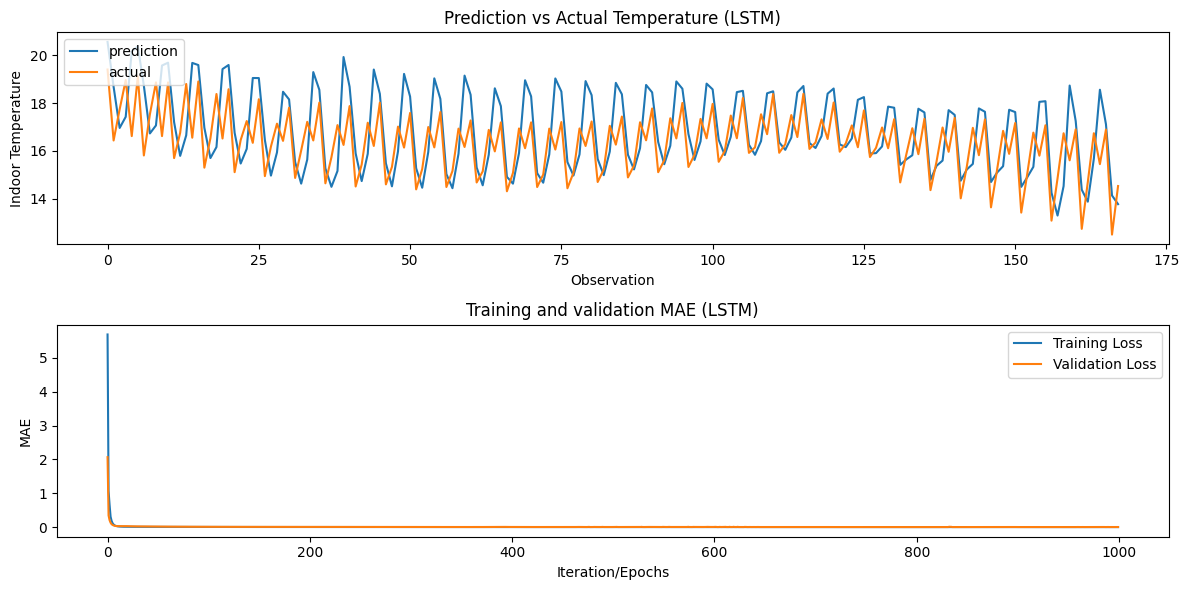

[[0.8631147744902092, 0.033689867100626075, 0.04597424602012035, 42661160272.834076, 0.6960968098763434, 0.06115932890350275, 0.07958277312925101, 0.09723789098585287]]


In [21]:
model = Sequential()
model.add(LSTM(units=16, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=False, activation='relu', name='LSTM_1'))
model.add(Dropout(0.1))
model.add(Dense(1, name='Output')) 

optimizer = Adam()
model.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

model.summary()

# fit network
history = model.fit(X_train, y_train, epochs=1000, batch_size=800,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'LSTM')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 16)             │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,513 (9.82 KB)

 Trainable params: 2,513 (9.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1200
15/15 - 1s - 45ms/step - loss: 0.2810 - mae: 0.5919 - val_loss: 0.3385 - val_mae: 0.6156
Epoch 2/1200
15/15 - 0s - 5ms/step - loss: 0.1414 - mae: 0.4234 - val_loss: 0.1103 - val_mae: 0.3634
Epoch 3/1200
15/15 - 0s - 5ms/step - loss: 0.0705 - mae: 0.2974 - val_loss: 0.0561 - val_mae: 0.2573
Epoch 4/1200
15/15 - 0s - 5ms/step - loss: 0.0510 - mae: 0.2537 - val_loss: 0.0394 - val_mae: 0.2198
Epoch 5/1200
15/15 - 0s - 5ms/step - loss: 0.0422 - mae: 0.2310 - val_loss: 0.0306 - val_mae: 0.1972
Epoch 6/1200
15/15 - 0s - 5ms/step - loss: 0.0356 - mae: 0.2119 - val_loss: 0.0258 - val_mae: 0.1809
Epoch 7/1200
15/15 - 0s - 5ms/step - loss: 0.0309 - mae: 0.1962 - val_loss: 0.0249 - val_mae: 0.1756
Epoch 8/1200
15/15 - 0s - 5ms/step - loss: 0.0282 - mae: 0.1875 - val_loss: 0.0212 - val_mae: 0.1624
Epoch 9/1200
15/15 - 0s - 5ms/step - loss: 0.0264 - mae: 0.1805 - val_loss: 0.0203 - val_mae: 0.1576
Epoch 10/1200
15/15 - 0s - 5ms/step - loss: 0.0243 - mae: 0.1723 - val_loss: 0.0228 - val_

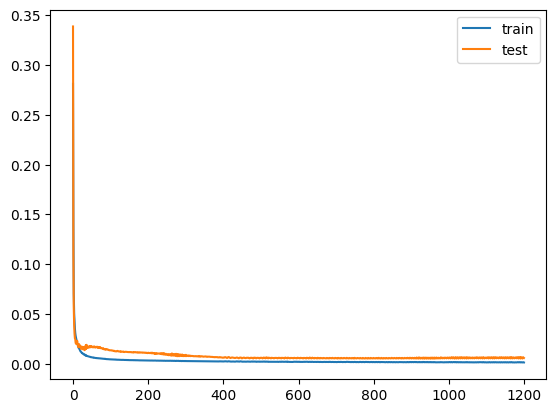

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
---------------------------------------------------
LSTM evaluation for train set:
{'Mean Absolute Error (MAE)': 0.038824076154268444, 'Mean Squared Error (MSE)': 0.0026484562192163556, 'Root Mean Squared Error (RMSE)': 0.05146315399600335, 'Mean Absolute Percentage Error (MAPE)': 32357756481.624218, 'R2 Score': 0.8284778772369283}
LSTM evaluation for test set:
{'Mean Absolute Error (MAE)': 0.09040601696172726, 'Mean Squared Error (MSE)': 0.01201806658350806, 'Root Mean Squared Error (RMSE)': 0.10962694278099731, 'Mean Absolute Percentage Error (MAPE)': 0.17885951142568643, 'R2 Score': 0.14653684918897292}
---------------------------------------------------



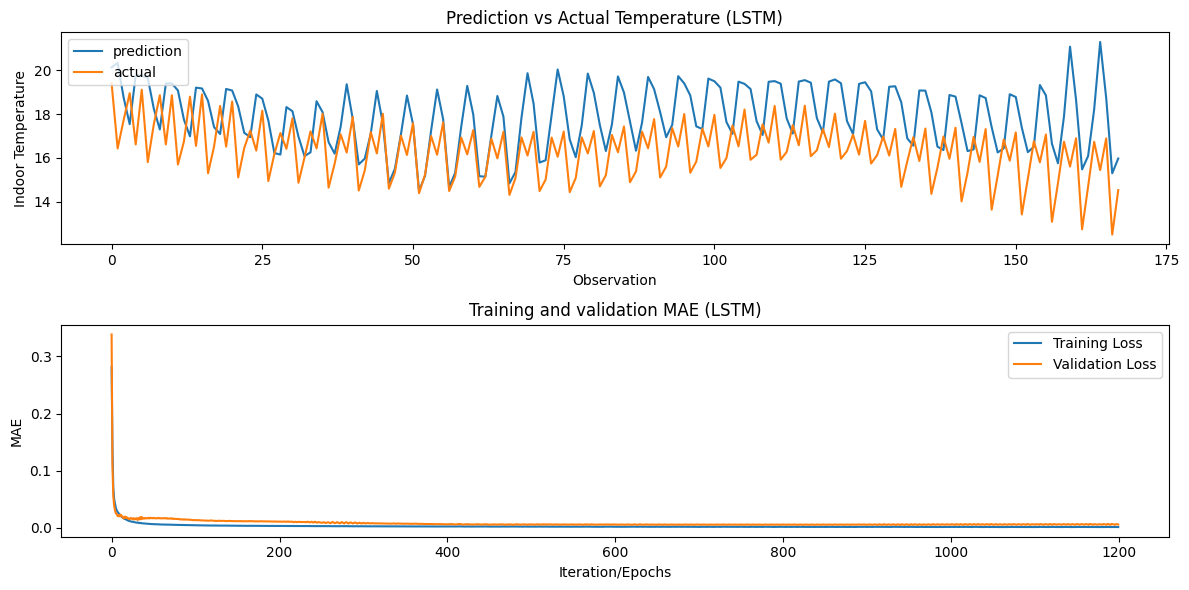

[[0.8284778772369283, 0.038824076154268444, 0.05146315399600335, 32357756481.624218, 0.14653684918897292, 0.09040601696172726, 0.10962694278099731, 0.17885951142568643]]


In [30]:
model = Sequential()
model.add(LSTM(units=16, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=False, activation='relu', name='LSTM_1'))
model.add(Dropout(0.1))
model.add(Dense(1, name='Output')) 

optimizer = Adam()
model.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

model.summary()

# fit network
history = model.fit(X_train, y_train, epochs=1200, batch_size=1400,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'LSTM')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 64)             │        22,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,337 (87.25 KB)

 Trainable params: 22,337 (87.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/400
39/39 - 1s - 24ms/step - loss: 0.4712 - mae: 0.8176 - val_loss: 0.1462 - val_mae: 0.4719
Epoch 2/400
39/39 - 0s - 7ms/step - loss: 0.0525 - mae: 0.2319 - val_loss: 0.0452 - val_mae: 0.2512
Epoch 3/400
39/39 - 0s - 6ms/step - loss: 0.0189 - mae: 0.1466 - val_loss: 0.0188 - val_mae: 0.1603
Epoch 4/400
39/39 - 0s - 7ms/step - loss: 0.0128 - mae: 0.1245 - val_loss: 0.0148 - val_mae: 0.1409
Epoch 5/400
39/39 - 0s - 7ms/step - loss: 0.0093 - mae: 0.1088 - val_loss: 0.0219 - val_mae: 0.1779
Epoch 6/400
39/39 - 0s - 7ms/step - loss: 0.0085 - mae: 0.1032 - val_loss: 0.0158 - val_mae: 0.1460
Epoch 7/400
39/39 - 0s - 7ms/step - loss: 0.0086 - mae: 0.1048 - val_loss: 0.0186 - val_mae: 0.1634
Epoch 8/400
39/39 - 0s - 6ms/step - loss: 0.0089 - mae: 0.1059 - val_loss: 0.0107 - val_mae: 0.1157
Epoch 9/400
39/39 - 0s - 7ms/step - loss: 0.0082 - mae: 0.1026 - val_loss: 0.0136 - val_mae: 0.1364
Epoch 10/400
39/39 - 0s - 7ms/step - loss: 0.0088 - mae: 0.1046 - val_loss: 0.0100 - val_mae: 0.110

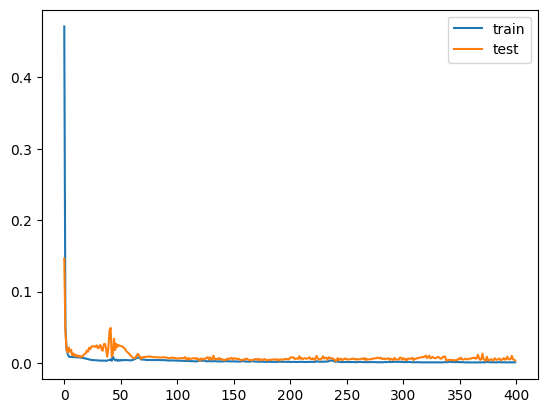

In [149]:
model = Sequential()
model.add(LSTM(units=6, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=False, activation='relu', name='LSTM_1'))
# Output layer
model.add(Dense(1, name='Output')) 

optimizer = Adam()
model.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

model.summary()

# fit network
history = model.fit(X_train, y_train, epochs=400, batch_size=512,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step
---------------------------------------------------
LSTM evaluation for train set:
{'Mean Absolute Error (MAE)': 0.040794972172797955, 'Mean Squared Error (MSE)': 0.0026836689053839013, 'Root Mean Squared Error (RMSE)': 0.05180413984793012, 'Mean Absolute Percentage Error (MAPE)': 27451453232.537617, 'R2 Score': 0.8261973960132537}
LSTM evaluation for test set:
{'Mean Absolute Error (MAE)': 0.06488052300323391, 'Mean Squared Error (MSE)': 0.007221728175313247, 'Root Mean Squared Error (RMSE)': 0.0849807517930575, 'Mean Absolute Percentage Error (MAPE)': 0.11894821022022484, 'R2 Score': 0.6002881488204117}
---------------------------------------------------



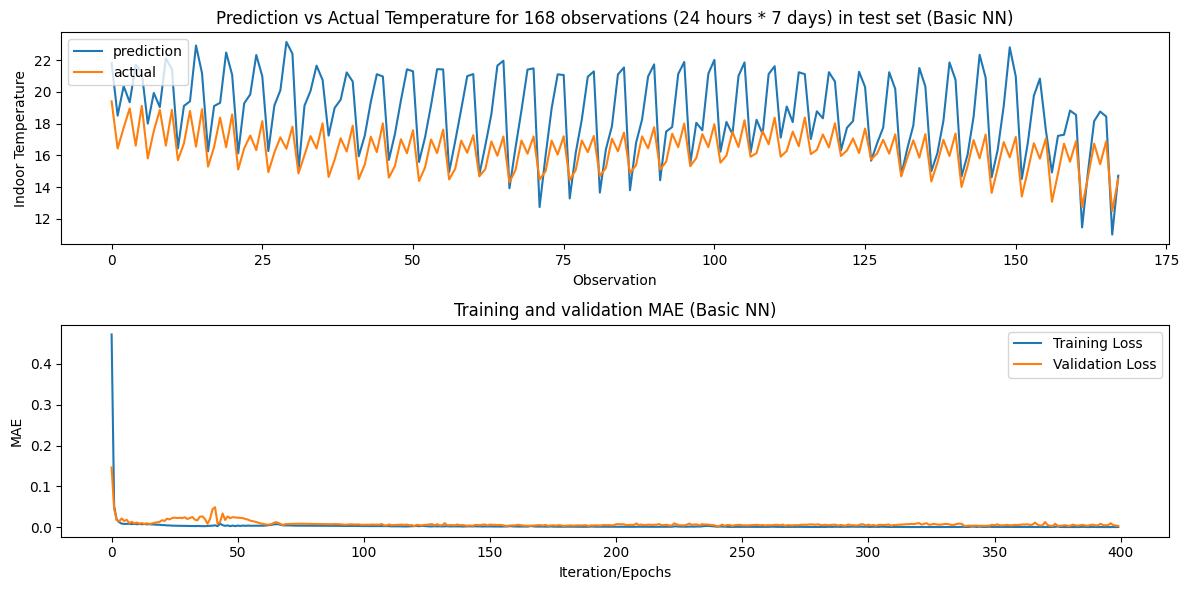

[[0.8261973960132537, 0.040794972172797955, 0.05180413984793012, 27451453232.537617, 0.6002881488204117, 0.06488052300323391, 0.0849807517930575, 0.11894821022022484]]


In [150]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'Basic NN')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 16)             │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,513 (9.82 KB)

 Trainable params: 2,513 (9.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
50/50 - 1s - 17ms/step - loss: 0.2587 - mae: 0.5540 - val_loss: 0.1125 - val_mae: 0.3888
Epoch 2/1000
50/50 - 0s - 2ms/step - loss: 0.0579 - mae: 0.2515 - val_loss: 0.0703 - val_mae: 0.3136
Epoch 3/1000
50/50 - 0s - 2ms/step - loss: 0.0300 - mae: 0.1817 - val_loss: 0.0553 - val_mae: 0.2868
Epoch 4/1000
50/50 - 0s - 2ms/step - loss: 0.0201 - mae: 0.1492 - val_loss: 0.0470 - val_mae: 0.2680
Epoch 5/1000
50/50 - 0s - 2ms/step - loss: 0.0150 - mae: 0.1305 - val_loss: 0.0412 - val_mae: 0.2527
Epoch 6/1000
50/50 - 0s - 2ms/step - loss: 0.0124 - mae: 0.1198 - val_loss: 0.0385 - val_mae: 0.2459
Epoch 7/1000
50/50 - 0s - 2ms/step - loss: 0.0105 - mae: 0.1117 - val_loss: 0.0357 - val_mae: 0.2374
Epoch 8/1000
50/50 - 0s - 2ms/step - loss: 0.0095 - mae: 0.1068 - val_loss: 0.0339 - val_mae: 0.2319
Epoch 9/1000
50/50 - 0s - 2ms/step - loss: 0.0088 - mae: 0.1032 - val_loss: 0.0324 - val_mae: 0.2271
Epoch 10/1000
50/50 - 0s - 2ms/step - loss: 0.0083 - mae: 0.1008 - val_loss: 0.0312 - val_

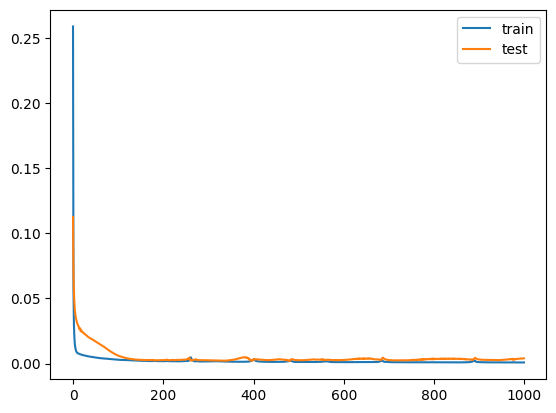

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
---------------------------------------------------
LSTM evaluation for train set:
{'Mean Absolute Error (MAE)': 0.03049059711984122, 'Mean Squared Error (MSE)': 0.00171157403973306, 'Root Mean Squared Error (RMSE)': 0.04137117401927409, 'Mean Absolute Percentage Error (MAPE)': 25379857960.337723, 'R2 Score': 0.8891532318219537}
LSTM evaluation for test set:
{'Mean Absolute Error (MAE)': 0.06959617032319224, 'Mean Squared Error (MSE)': 0.007977089726848168, 'Root Mean Squared Error (RMSE)': 0.08931455495521527, 'Mean Absolute Percentage Error (MAPE)': 0.18585545865564224, 'R2 Score': 0.5295573191176249}
---------------------------------------------------



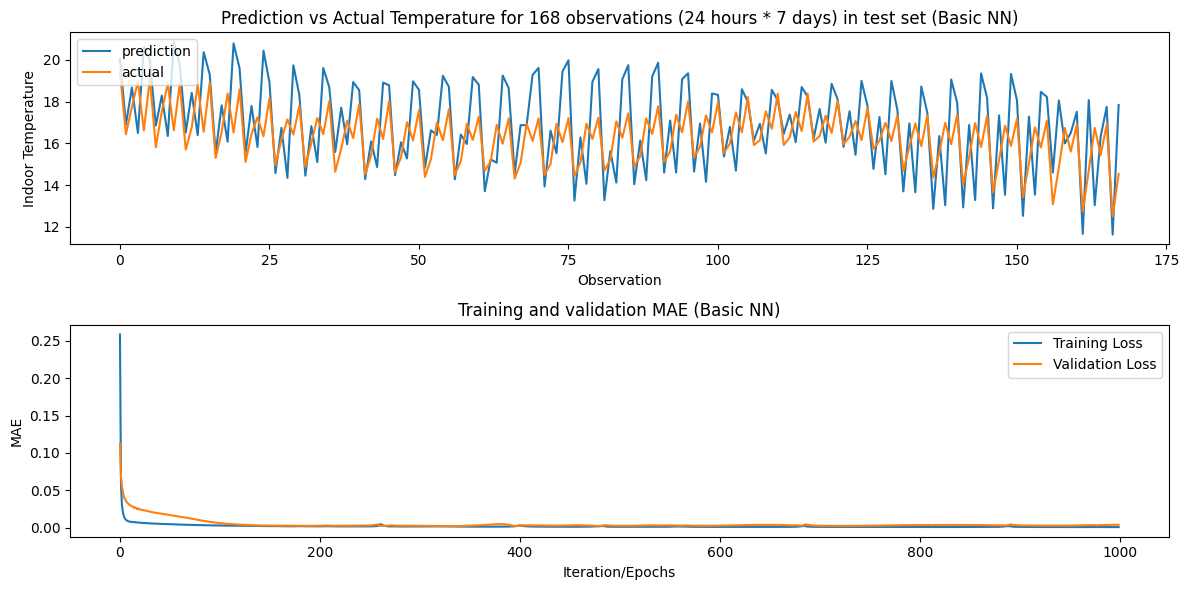

[[0.8891532318219537, 0.03049059711984122, 0.04137117401927409, 25379857960.337723, 0.5295573191176249, 0.06959617032319224, 0.08931455495521527, 0.18585545865564224]]


In [173]:
# design network
model = Sequential()
model.add(LSTM(units=16, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=False, activation='relu', name='LSTM_1'))
# Output layer
model.add(Dense(1, name='Output')) 

optimizer = Adam()
model.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

model.summary()

# fit network
history = model.fit(X_train, y_train, epochs=1000, batch_size=400,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'Basic NN')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 16)             │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,513 (9.82 KB)

 Trainable params: 2,513 (9.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
50/50 - 2s - 44ms/step - loss: 1.4265 - mae: 1.8547 - val_loss: 0.0846 - val_mae: 0.3278
Epoch 2/1000
50/50 - 0s - 3ms/step - loss: 0.3711 - mae: 0.7108 - val_loss: 0.0566 - val_mae: 0.2831
Epoch 3/1000
50/50 - 0s - 2ms/step - loss: 0.1114 - mae: 0.3610 - val_loss: 0.0514 - val_mae: 0.2853
Epoch 4/1000
50/50 - 0s - 2ms/step - loss: 0.0535 - mae: 0.2539 - val_loss: 0.0459 - val_mae: 0.2718
Epoch 5/1000
50/50 - 0s - 2ms/step - loss: 0.0386 - mae: 0.2189 - val_loss: 0.0454 - val_mae: 0.2727
Epoch 6/1000
50/50 - 0s - 2ms/step - loss: 0.0307 - mae: 0.1969 - val_loss: 0.0439 - val_mae: 0.2688
Epoch 7/1000
50/50 - 0s - 2ms/step - loss: 0.0251 - mae: 0.1777 - val_loss: 0.0404 - val_mae: 0.2575
Epoch 8/1000
50/50 - 0s - 2ms/step - loss: 0.0212 - mae: 0.1635 - val_loss: 0.0426 - val_mae: 0.2663
Epoch 9/1000
50/50 - 0s - 2ms/step - loss: 0.0184 - mae: 0.1523 - val_loss: 0.0419 - val_mae: 0.2650
Epoch 10/1000
50/50 - 0s - 2ms/step - loss: 0.0165 - mae: 0.1441 - val_loss: 0.0401 - val_

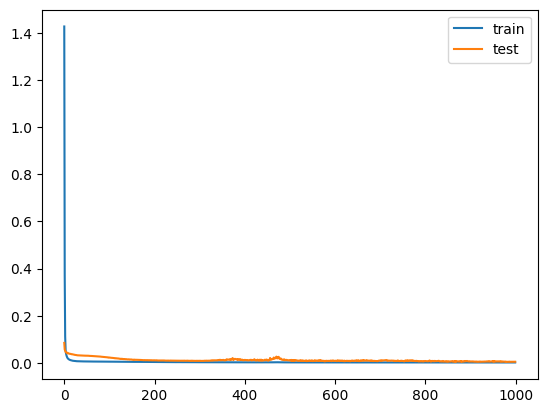

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
---------------------------------------------------
LSTM evaluation for train set:
{'Mean Absolute Error (MAE)': 0.03228946834207603, 'Mean Squared Error (MSE)': 0.0019498168170490222, 'Root Mean Squared Error (RMSE)': 0.04415673014444143, 'Mean Absolute Percentage Error (MAPE)': 41826702914.66251, 'R2 Score': 0.8737239011040403}
LSTM evaluation for test set:
{'Mean Absolute Error (MAE)': 0.07141092674646486, 'Mean Squared Error (MSE)': 0.009337357916278738, 'Root Mean Squared Error (RMSE)': 0.09663000525860867, 'Mean Absolute Percentage Error (MAPE)': 0.12559358058526, 'R2 Score': 0.5719786734526797}
---------------------------------------------------



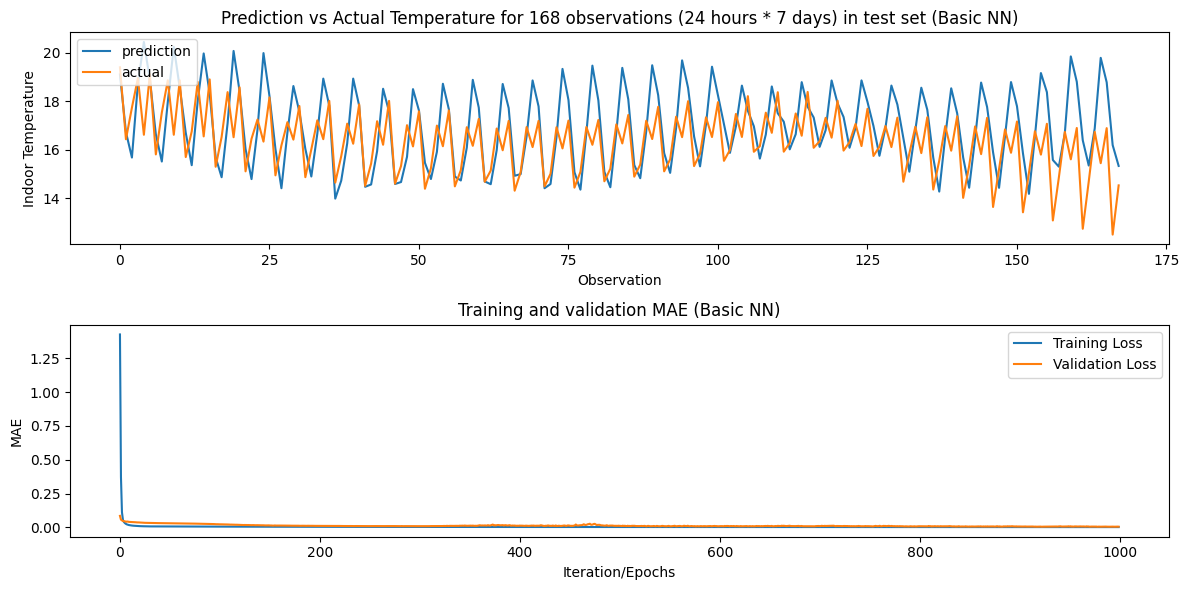

[[0.8737239011040403, 0.03228946834207603, 0.04415673014444143, 41826702914.66251, 0.5719786734526797, 0.07141092674646486, 0.09663000525860867, 0.12559358058526]]


In [174]:
# design network
model = Sequential()
model.add(LSTM(units=16, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=False, activation='relu', name='LSTM_1'))
model.add(Dropout(0.3))
model.add(Dense(1, name='Output')) 

optimizer = Adam()
model.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

model.summary()

# fit network
history = model.fit(X_train, y_train, epochs=1000, batch_size=400,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'Basic NN')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 16)             │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,513 (9.82 KB)

 Trainable params: 2,513 (9.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
50/50 - 2s - 44ms/step - loss: 2.5631 - mae: 3.0196 - val_loss: 0.6762 - val_mae: 1.1045
Epoch 2/1000
50/50 - 0s - 2ms/step - loss: 0.6104 - mae: 0.9712 - val_loss: 0.1968 - val_mae: 0.5163
Epoch 3/1000
50/50 - 0s - 2ms/step - loss: 0.4020 - mae: 0.7133 - val_loss: 0.1098 - val_mae: 0.3927
Epoch 4/1000
50/50 - 0s - 2ms/step - loss: 0.2689 - mae: 0.5341 - val_loss: 0.0701 - val_mae: 0.3126
Epoch 5/1000
50/50 - 0s - 2ms/step - loss: 0.1554 - mae: 0.3865 - val_loss: 0.0647 - val_mae: 0.3144
Epoch 6/1000
50/50 - 0s - 2ms/step - loss: 0.0771 - mae: 0.2721 - val_loss: 0.0674 - val_mae: 0.3258
Epoch 7/1000
50/50 - 0s - 2ms/step - loss: 0.0440 - mae: 0.2122 - val_loss: 0.0674 - val_mae: 0.3283
Epoch 8/1000
50/50 - 0s - 2ms/step - loss: 0.0311 - mae: 0.1834 - val_loss: 0.0633 - val_mae: 0.3201
Epoch 9/1000
50/50 - 0s - 2ms/step - loss: 0.0221 - mae: 0.1557 - val_loss: 0.0401 - val_mae: 0.2529
Epoch 10/1000
50/50 - 0s - 2ms/step - loss: 0.0180 - mae: 0.1396 - val_loss: 0.0191 - val_

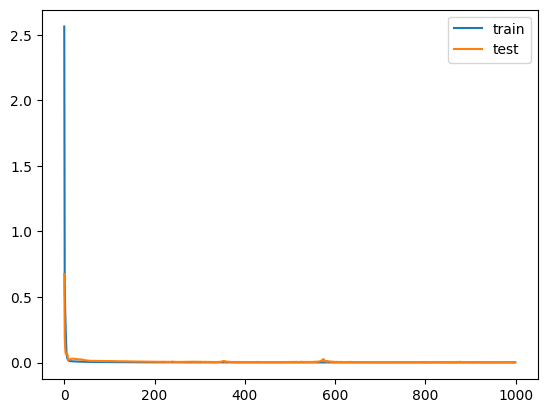

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
---------------------------------------------------
LSTM evaluation for train set:
{'Mean Absolute Error (MAE)': 0.03296865895078525, 'Mean Squared Error (MSE)': 0.0020390240229648197, 'Root Mean Squared Error (RMSE)': 0.045155553622614565, 'Mean Absolute Percentage Error (MAPE)': 37173089481.10048, 'R2 Score': 0.867946569686054}
LSTM evaluation for test set:
{'Mean Absolute Error (MAE)': 0.062016426230993384, 'Mean Squared Error (MSE)': 0.007101178332952635, 'Root Mean Squared Error (RMSE)': 0.0842684895613576, 'Mean Absolute Percentage Error (MAPE)': 0.1085595988341118, 'R2 Score': 0.6033941806290406}
---------------------------------------------------



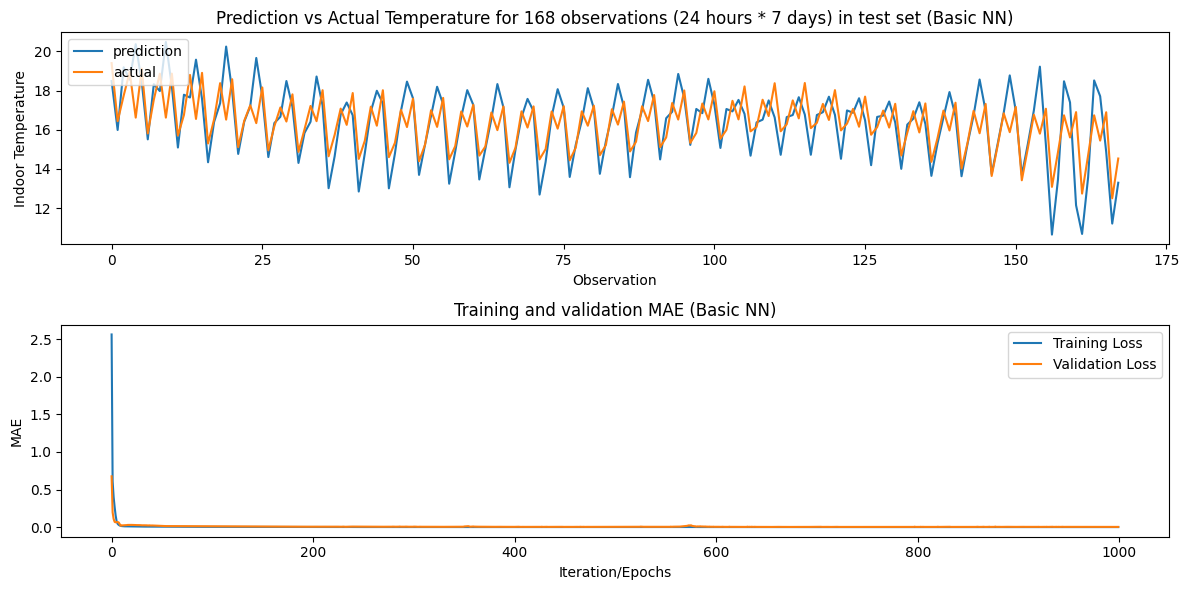

[[0.867946569686054, 0.03296865895078525, 0.045155553622614565, 37173089481.10048, 0.6033941806290406, 0.062016426230993384, 0.0842684895613576, 0.1085595988341118]]


In [181]:
# design network
model = Sequential()
model.add(LSTM(units=16, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=False, activation='relu', name='LSTM_1'))
model.add(Dropout(0.1))
model.add(Dense(1, name='Output')) 

optimizer = Adam()
model.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

model.summary()

# fit network
history = model.fit(X_train, y_train, epochs=1000, batch_size=400,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'Basic NN')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 16)             │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,513 (9.82 KB)

 Trainable params: 2,513 (9.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
50/50 - 3s - 54ms/step - loss: 0.1399 - mae: 0.4385 - val_loss: 0.0456 - val_mae: 0.2582
Epoch 2/1000
50/50 - 0s - 3ms/step - loss: 0.0284 - mae: 0.1897 - val_loss: 0.0415 - val_mae: 0.2488
Epoch 3/1000
50/50 - 0s - 2ms/step - loss: 0.0250 - mae: 0.1775 - val_loss: 0.0401 - val_mae: 0.2460
Epoch 4/1000
50/50 - 0s - 2ms/step - loss: 0.0239 - mae: 0.1732 - val_loss: 0.0395 - val_mae: 0.2459
Epoch 5/1000
50/50 - 0s - 7ms/step - loss: 0.0217 - mae: 0.1650 - val_loss: 0.0386 - val_mae: 0.2441
Epoch 6/1000
50/50 - 0s - 4ms/step - loss: 0.0202 - mae: 0.1595 - val_loss: 0.0366 - val_mae: 0.2384
Epoch 7/1000
50/50 - 0s - 3ms/step - loss: 0.0183 - mae: 0.1506 - val_loss: 0.0348 - val_mae: 0.2329
Epoch 8/1000
50/50 - 0s - 2ms/step - loss: 0.0164 - mae: 0.1427 - val_loss: 0.0332 - val_mae: 0.2283
Epoch 9/1000
50/50 - 0s - 2ms/step - loss: 0.0158 - mae: 0.1388 - val_loss: 0.0321 - val_mae: 0.2249
Epoch 10/1000
50/50 - 0s - 2ms/step - loss: 0.0147 - mae: 0.1333 - val_loss: 0.0311 - val_

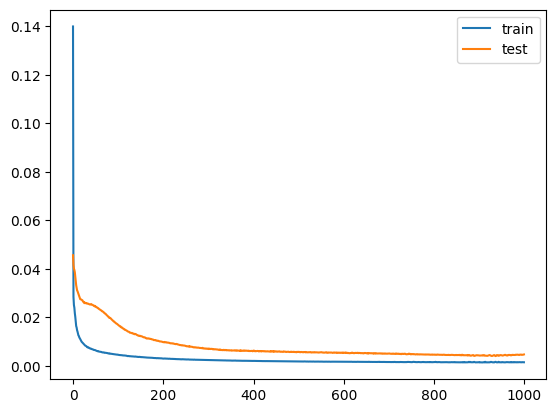

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
---------------------------------------------------
LSTM evaluation for train set:
{'Mean Absolute Error (MAE)': 0.04932132783543404, 'Mean Squared Error (MSE)': 0.0039740118679943695, 'Root Mean Squared Error (RMSE)': 0.06303976418098635, 'Mean Absolute Percentage Error (MAPE)': 34767373223.686966, 'R2 Score': 0.7426308403596267}
LSTM evaluation for test set:
{'Mean Absolute Error (MAE)': 0.0759868489763779, 'Mean Squared Error (MSE)': 0.009347021143782759, 'Root Mean Squared Error (RMSE)': 0.0966799935032205, 'Mean Absolute Percentage Error (MAPE)': 0.12921096580825667, 'R2 Score': -0.48714320502560793}
---------------------------------------------------



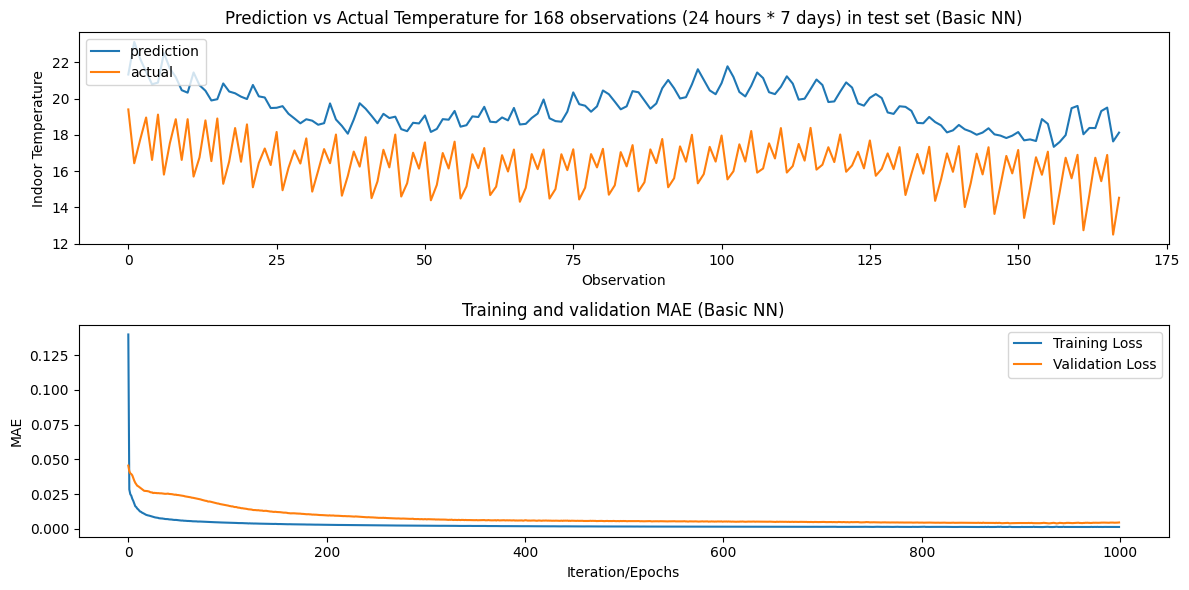

[[0.7426308403596267, 0.04932132783543404, 0.06303976418098635, 34767373223.686966, -0.48714320502560793, 0.0759868489763779, 0.0966799935032205, 0.12921096580825667]]


In [182]:
# design network
model = Sequential()
model.add(LSTM(units=16, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=False, activation='sigmoid', name='LSTM_1'))
model.add(Dropout(0.1))
model.add(Dense(1, name='Output')) 

optimizer = Adam()
model.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

model.summary()

# fit network
history = model.fit(X_train, y_train, epochs=1000, batch_size=400,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'Basic NN')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 16)             │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,513 (9.82 KB)

 Trainable params: 2,513 (9.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
50/50 - 3s - 67ms/step - loss: 0.0393 - mae: 0.2221 - val_loss: 0.0425 - val_mae: 0.2509
Epoch 2/1000
50/50 - 0s - 2ms/step - loss: 0.0220 - mae: 0.1636 - val_loss: 0.0358 - val_mae: 0.2328
Epoch 3/1000
50/50 - 0s - 2ms/step - loss: 0.0174 - mae: 0.1467 - val_loss: 0.0354 - val_mae: 0.2338
Epoch 4/1000
50/50 - 0s - 2ms/step - loss: 0.0146 - mae: 0.1348 - val_loss: 0.0366 - val_mae: 0.2401
Epoch 5/1000
50/50 - 0s - 2ms/step - loss: 0.0128 - mae: 0.1265 - val_loss: 0.0392 - val_mae: 0.2508
Epoch 6/1000
50/50 - 0s - 2ms/step - loss: 0.0123 - mae: 0.1244 - val_loss: 0.0409 - val_mae: 0.2581
Epoch 7/1000
50/50 - 0s - 2ms/step - loss: 0.0115 - mae: 0.1203 - val_loss: 0.0418 - val_mae: 0.2622
Epoch 8/1000
50/50 - 0s - 2ms/step - loss: 0.0110 - mae: 0.1176 - val_loss: 0.0421 - val_mae: 0.2632
Epoch 9/1000
50/50 - 0s - 2ms/step - loss: 0.0105 - mae: 0.1152 - val_loss: 0.0410 - val_mae: 0.2598
Epoch 10/1000
50/50 - 0s - 2ms/step - loss: 0.0101 - mae: 0.1126 - val_loss: 0.0402 - val_

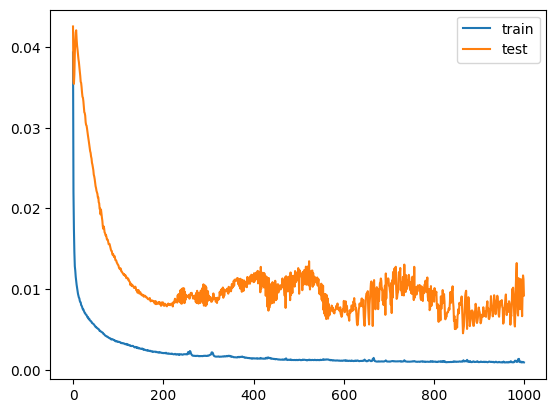

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
---------------------------------------------------
LSTM evaluation for train set:
{'Mean Absolute Error (MAE)': 0.02985476012000756, 'Mean Squared Error (MSE)': 0.001631078697187175, 'Root Mean Squared Error (RMSE)': 0.04038661532224723, 'Mean Absolute Percentage Error (MAPE)': 43324687447.068436, 'R2 Score': 0.8943663563304253}
LSTM evaluation for test set:
{'Mean Absolute Error (MAE)': 0.11204406677798236, 'Mean Squared Error (MSE)': 0.018427014750111447, 'Root Mean Squared Error (RMSE)': 0.13574614082953315, 'Mean Absolute Percentage Error (MAPE)': 0.24952590375688333, 'R2 Score': -0.269490957228925}
---------------------------------------------------



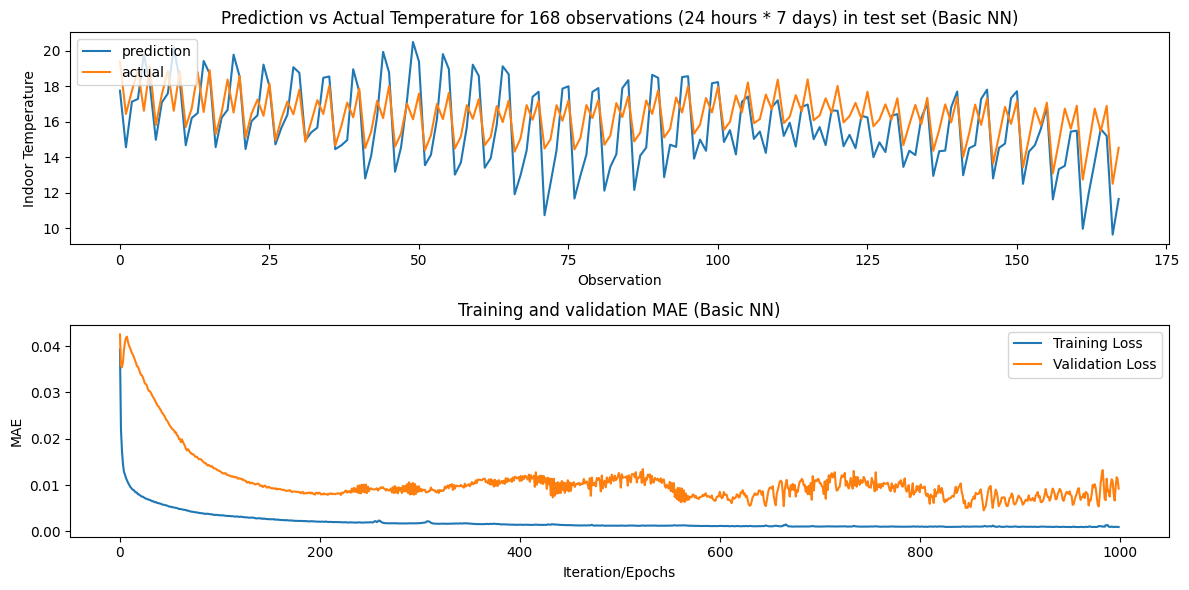

[[0.8943663563304253, 0.02985476012000756, 0.04038661532224723, 43324687447.068436, -0.269490957228925, 0.11204406677798236, 0.13574614082953315, 0.24952590375688333]]


In [183]:
# design network
model = Sequential()
model.add(LSTM(units=16, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=False, activation='tanh', name='LSTM_1'))
model.add(Dropout(0.1))
model.add(Dense(1, name='Output')) 

optimizer = Adam()
model.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

model.summary()

# fit network
history = model.fit(X_train, y_train, epochs=1000, batch_size=400,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'Basic NN')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 8)              │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,001 (3.91 KB)

 Trainable params: 1,001 (3.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
50/50 - 3s - 50ms/step - loss: 0.4992 - mae: 0.8405 - val_loss: 0.1534 - val_mae: 0.5069
Epoch 2/1000
50/50 - 0s - 3ms/step - loss: 0.3338 - mae: 0.6473 - val_loss: 0.1321 - val_mae: 0.4698
Epoch 3/1000
50/50 - 0s - 2ms/step - loss: 0.2199 - mae: 0.4925 - val_loss: 0.1145 - val_mae: 0.4371
Epoch 4/1000
50/50 - 0s - 2ms/step - loss: 0.1450 - mae: 0.3850 - val_loss: 0.1076 - val_mae: 0.4242
Epoch 5/1000
50/50 - 0s - 2ms/step - loss: 0.0993 - mae: 0.3113 - val_loss: 0.0999 - val_mae: 0.4084
Epoch 6/1000
50/50 - 0s - 2ms/step - loss: 0.0693 - mae: 0.2586 - val_loss: 0.0867 - val_mae: 0.3774
Epoch 7/1000
50/50 - 0s - 2ms/step - loss: 0.0516 - mae: 0.2247 - val_loss: 0.0771 - val_mae: 0.3488
Epoch 8/1000
50/50 - 0s - 2ms/step - loss: 0.0375 - mae: 0.1950 - val_loss: 0.0777 - val_mae: 0.3559
Epoch 9/1000
50/50 - 0s - 2ms/step - loss: 0.0300 - mae: 0.1792 - val_loss: 0.0702 - val_mae: 0.3343
Epoch 10/1000
50/50 - 0s - 2ms/step - loss: 0.0242 - mae: 0.1637 - val_loss: 0.0685 - val_

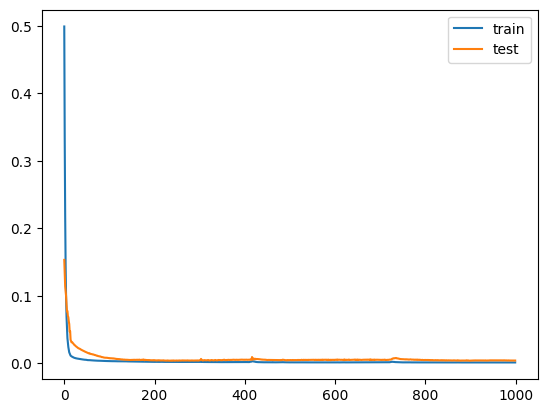

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step
---------------------------------------------------
LSTM evaluation for train set:
{'Mean Absolute Error (MAE)': 0.04061347000388073, 'Mean Squared Error (MSE)': 0.002891813324652999, 'Root Mean Squared Error (RMSE)': 0.05377558297827183, 'Mean Absolute Percentage Error (MAPE)': 22567540133.63215, 'R2 Score': 0.8127173269921822}
LSTM evaluation for test set:
{'Mean Absolute Error (MAE)': 0.07246853566908644, 'Mean Squared Error (MSE)': 0.008456404135933612, 'Root Mean Squared Error (RMSE)': 0.09195870886399837, 'Mean Absolute Percentage Error (MAPE)': 0.12395033331967117, 'R2 Score': 0.4324805925588421}
---------------------------------------------------



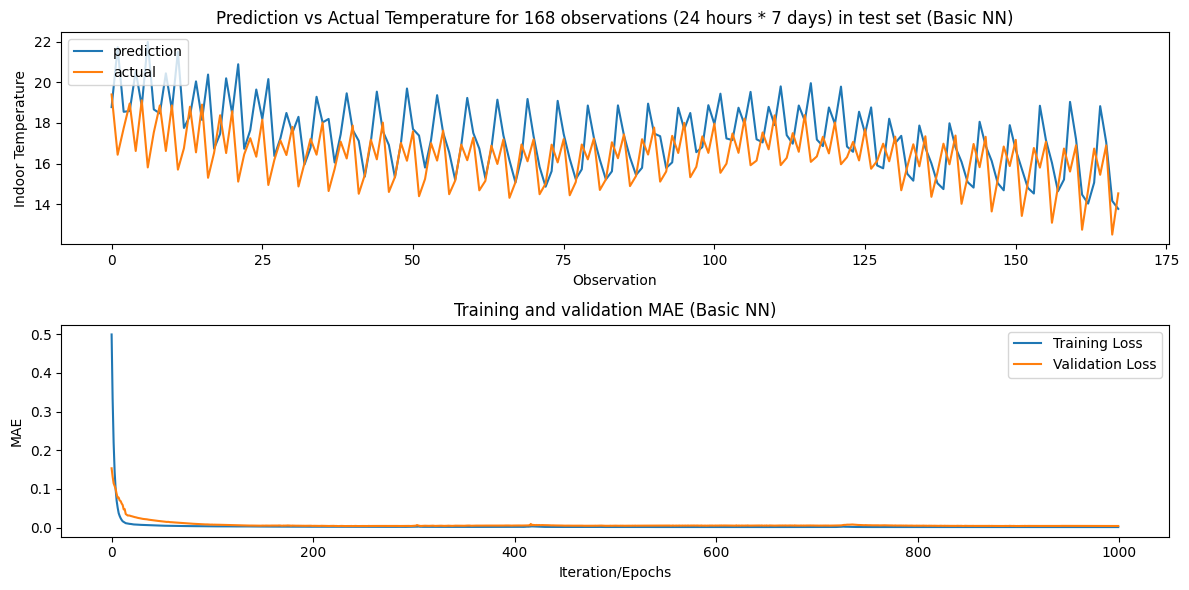

[[0.8127173269921822, 0.04061347000388073, 0.05377558297827183, 22567540133.63215, 0.4324805925588421, 0.07246853566908644, 0.09195870886399837, 0.12395033331967117]]


In [184]:
# design network
model = Sequential()
model.add(LSTM(units=8, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=False, activation='relu', name='LSTM_1'))
model.add(Dropout(0.1))
model.add(Dense(1, name='Output')) 

optimizer = Adam()
model.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

model.summary()

# fit network
history = model.fit(X_train, y_train, epochs=1000, batch_size=400,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'Basic NN')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 32)             │         7,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,073 (27.63 KB)

 Trainable params: 7,073 (27.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
50/50 - 3s - 70ms/step - loss: 0.8750 - mae: 1.2724 - val_loss: 0.1212 - val_mae: 0.3877
Epoch 2/1000
50/50 - 0s - 4ms/step - loss: 0.3127 - mae: 0.6276 - val_loss: 0.0356 - val_mae: 0.2168
Epoch 3/1000
50/50 - 0s - 3ms/step - loss: 0.2082 - mae: 0.4877 - val_loss: 0.0369 - val_mae: 0.2319
Epoch 4/1000
50/50 - 0s - 3ms/step - loss: 0.1207 - mae: 0.3634 - val_loss: 0.0191 - val_mae: 0.1578
Epoch 5/1000
50/50 - 0s - 3ms/step - loss: 0.0740 - mae: 0.2844 - val_loss: 0.0140 - val_mae: 0.1332
Epoch 6/1000
50/50 - 0s - 3ms/step - loss: 0.0487 - mae: 0.2318 - val_loss: 0.0163 - val_mae: 0.1481
Epoch 7/1000
50/50 - 0s - 3ms/step - loss: 0.0353 - mae: 0.2021 - val_loss: 0.0175 - val_mae: 0.1549
Epoch 8/1000
50/50 - 0s - 3ms/step - loss: 0.0271 - mae: 0.1779 - val_loss: 0.0197 - val_mae: 0.1691
Epoch 9/1000
50/50 - 0s - 3ms/step - loss: 0.0218 - mae: 0.1619 - val_loss: 0.0202 - val_mae: 0.1731
Epoch 10/1000
50/50 - 0s - 3ms/step - loss: 0.0172 - mae: 0.1445 - val_loss: 0.0203 - val_

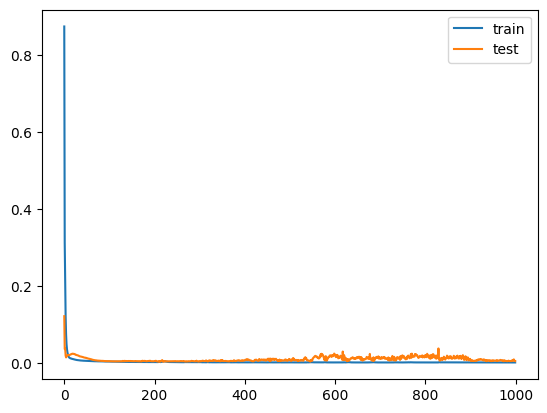

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step
---------------------------------------------------
LSTM evaluation for train set:
{'Mean Absolute Error (MAE)': 0.030854768088670433, 'Mean Squared Error (MSE)': 0.0017387186221020524, 'Root Mean Squared Error (RMSE)': 0.04169794505850441, 'Mean Absolute Percentage Error (MAPE)': 18587061383.714375, 'R2 Score': 0.8873952656695722}
LSTM evaluation for test set:
{'Mean Absolute Error (MAE)': 0.07206226009582901, 'Mean Squared Error (MSE)': 0.00913649783888214, 'Root Mean Squared Error (RMSE)': 0.09558502936591137, 'Mean Absolute Percentage Error (MAPE)': 0.11786349647495543, 'R2 Score': 0.48745987300089455}
---------------------------------------------------



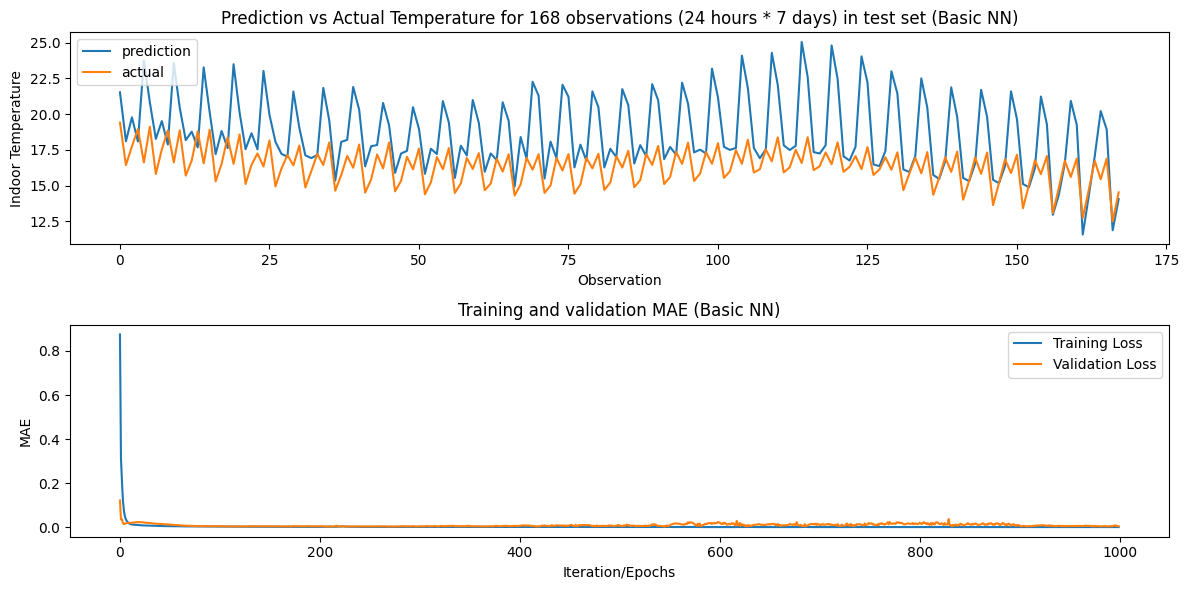

[[0.8873952656695722, 0.030854768088670433, 0.04169794505850441, 18587061383.714375, 0.48745987300089455, 0.07206226009582901, 0.09558502936591137, 0.11786349647495543]]


In [185]:
# design network
model = Sequential()
model.add(LSTM(units=32, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=False, activation='relu', name='LSTM_1'))
model.add(Dropout(0.1))
model.add(Dense(1, name='Output')) 

optimizer = Adam()
model.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

model.summary()

# fit network
history = model.fit(X_train, y_train, epochs=1000, batch_size=400,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'Basic NN')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

In [ ]:
# design network
model = Sequential()
optimizer = Adam()
model.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

model.summary()

# fit network
history = model.fit(X_train, y_train, epochs=1000, batch_size=400,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'Basic NN')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 16)             │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,513 (9.82 KB)

 Trainable params: 2,513 (9.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2000
50/50 - 2s - 33ms/step - loss: 0.8837 - mae: 1.2615 - val_loss: 0.0753 - val_mae: 0.3354
Epoch 2/2000
50/50 - 0s - 2ms/step - loss: 0.1587 - mae: 0.4445 - val_loss: 0.0435 - val_mae: 0.2432
Epoch 3/2000
50/50 - 0s - 2ms/step - loss: 0.0863 - mae: 0.3298 - val_loss: 0.0463 - val_mae: 0.2543
Epoch 4/2000
50/50 - 0s - 3ms/step - loss: 0.0540 - mae: 0.2656 - val_loss: 0.0402 - val_mae: 0.2410
Epoch 5/2000
50/50 - 0s - 3ms/step - loss: 0.0371 - mae: 0.2210 - val_loss: 0.0382 - val_mae: 0.2393
Epoch 6/2000
50/50 - 0s - 3ms/step - loss: 0.0228 - mae: 0.1724 - val_loss: 0.0344 - val_mae: 0.2298
Epoch 7/2000
50/50 - 0s - 2ms/step - loss: 0.0180 - mae: 0.1528 - val_loss: 0.0350 - val_mae: 0.2333
Epoch 8/2000
50/50 - 0s - 2ms/step - loss: 0.0158 - mae: 0.1422 - val_loss: 0.0343 - val_mae: 0.2320
Epoch 9/2000
50/50 - 0s - 2ms/step - loss: 0.0146 - mae: 0.1367 - val_loss: 0.0341 - val_mae: 0.2308
Epoch 10/2000
50/50 - 0s - 2ms/step - loss: 0.0140 - mae: 0.1334 - val_loss: 0.0338 - val_

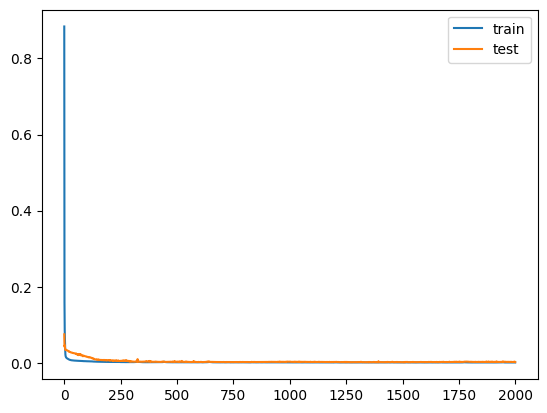

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
---------------------------------------------------
LSTM evaluation for train set:
{'Mean Absolute Error (MAE)': 0.03385326943804589, 'Mean Squared Error (MSE)': 0.0020157995447676034, 'Root Mean Squared Error (RMSE)': 0.04489765633936368, 'Mean Absolute Percentage Error (MAPE)': 10382426240.72881, 'R2 Score': 0.8694506579060322}
LSTM evaluation for test set:
{'Mean Absolute Error (MAE)': 0.056678869342098, 'Mean Squared Error (MSE)': 0.00511562610351823, 'Root Mean Squared Error (RMSE)': 0.07152360521896411, 'Mean Absolute Percentage Error (MAPE)': 0.10076502339250937, 'R2 Score': 0.5341118348306391}
---------------------------------------------------



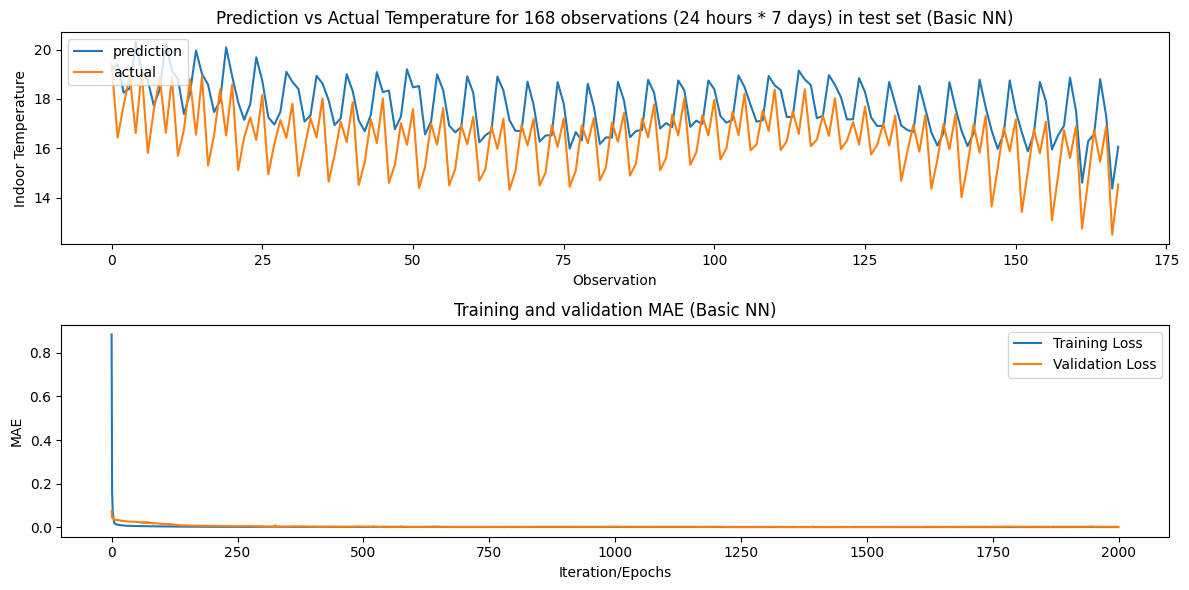

[[0.8694506579060322, 0.03385326943804589, 0.04489765633936368, 10382426240.72881, 0.5341118348306391, 0.056678869342098, 0.07152360521896411, 0.10076502339250937]]


In [179]:
# design network
model = Sequential()
model.add(LSTM(units=16, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=False, activation='relu', name='LSTM_1'))
model.add(Dropout(0.3))
model.add(Dense(1, name='Output')) 

optimizer = Adam()
model.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

model.summary()

# fit network
history = model.fit(X_train, y_train, epochs=2000, batch_size=400,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'Basic NN')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 6, 16)          │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 6, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 256)            │       279,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,305 (1.08 MB)

 Trainable params: 282,305 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
50/50 - 8s - 162ms/step - loss: 0.0393 - mae: 0.2055 - val_loss: 0.0125 - val_mae: 0.1286
Epoch 2/1000
50/50 - 2s - 37ms/step - loss: 0.0108 - mae: 0.1160 - val_loss: 0.0130 - val_mae: 0.1363
Epoch 3/1000
50/50 - 4s - 81ms/step - loss: 0.0094 - mae: 0.1069 - val_loss: 0.0131 - val_mae: 0.1374
Epoch 4/1000
50/50 - 3s - 57ms/step - loss: 0.0089 - mae: 0.1036 - val_loss: 0.0138 - val_mae: 0.1415
Epoch 5/1000
50/50 - 2s - 41ms/step - loss: 0.0086 - mae: 0.1020 - val_loss: 0.0145 - val_mae: 0.1459
Epoch 6/1000
50/50 - 2s - 37ms/step - loss: 0.0083 - mae: 0.0998 - val_loss: 0.0148 - val_mae: 0.1478
Epoch 7/1000
50/50 - 2s - 47ms/step - loss: 0.0082 - mae: 0.0990 - val_loss: 0.0153 - val_mae: 0.1506
Epoch 8/1000
50/50 - 2s - 30ms/step - loss: 0.0080 - mae: 0.0985 - val_loss: 0.0156 - val_mae: 0.1528
Epoch 9/1000
50/50 - 2s - 35ms/step - loss: 0.0080 - mae: 0.0985 - val_loss: 0.0167 - val_mae: 0.1592
Epoch 10/1000
50/50 - 2s - 36ms/step - loss: 0.0080 - mae: 0.0982 - val_loss: 0.0

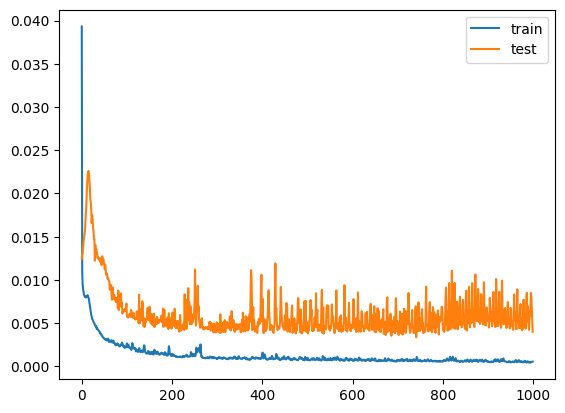

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
---------------------------------------------------
LSTM evaluation for train set:
{'Mean Absolute Error (MAE)': 0.034645122805285984, 'Mean Squared Error (MSE)': 0.0021182914203784382, 'Root Mean Squared Error (RMSE)': 0.0460249000040026, 'Mean Absolute Percentage Error (MAPE)': 24235086258.885674, 'R2 Score': 0.8628129706589533}
LSTM evaluation for test set:
{'Mean Absolute Error (MAE)': 0.07179713860477624, 'Mean Squared Error (MSE)': 0.00798349868119971, 'Root Mean Squared Error (RMSE)': 0.08935042630675978, 'Mean Absolute Percentage Error (MAPE)': 0.13181627510557078, 'R2 Score': 0.459719960699838}
---------------------------------------------------



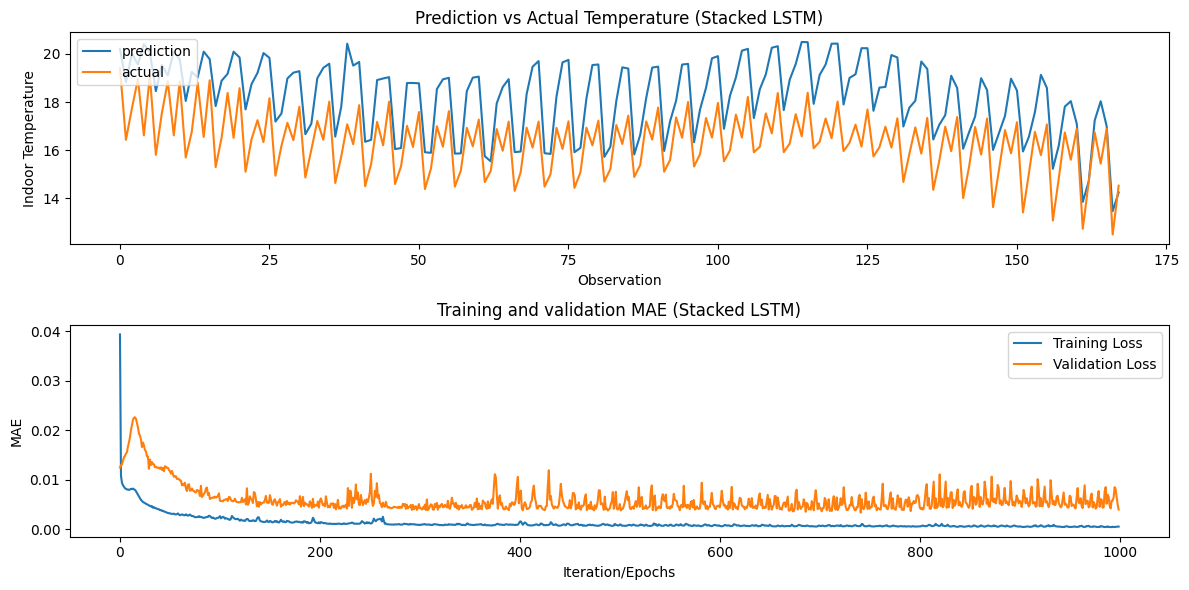

[[0.8628129706589533, 0.034645122805285984, 0.0460249000040026, 24235086258.885674, 0.459719960699838, 0.07179713860477624, 0.08935042630675978, 0.13181627510557078]]


In [188]:
# design network
model = Sequential()
model.add(LSTM(units=16, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=True, activation='relu', name='LSTM_1'))
model.add(Dropout(0.1))
model.add(LSTM(units=256, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=False, activation='relu', name='LSTM_2'))
model.add(Dropout(0.1))
model.add(Dense(1, name='Output')) 

optimizer = Adam()
model.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

model.summary()

# fit network
history = model.fit(X_train, y_train, epochs=1000, batch_size=400,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'Stacked LSTM')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

Model: "functional_331"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_82      │ (None, 6, 22)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 6, 22)     │          0 │ input_layer_82[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_2 (Masking) │ (None, 6, 22)     │          0 │ input_layer_82[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_2 (Any)         │ (None, 6)         │          0 │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_37 (LSTM)      │ (None, 6, 16)     │      2,496 │ masking_2[0][0],  │
│                     │                   │            │ any_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_4 (Dot)         │ (None, 6, 6)      │          0 │ lstm_37[0][0],    │
│                     │                   │            │ lstm_37[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 6, 6)      │         42 │ dot_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_5 (Dot)         │ (None, 6, 16)     │          0 │ dense_52[0][0],   │
│                     │                   │            │ lstm_37[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_25          │ (None, 96)        │          0 │ dot_5[0][0]       │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 1)         │         97 │ flatten_25[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,635 (10.29 KB)

 Trainable params: 2,635 (10.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
50/50 - 3s - 61ms/step - loss: 0.1456 - mae: 0.4036 - val_loss: 0.0380 - val_mae: 0.2371
Epoch 2/1000
50/50 - 0s - 3ms/step - loss: 0.0129 - mae: 0.1264 - val_loss: 0.0286 - val_mae: 0.2074
Epoch 3/1000
50/50 - 0s - 3ms/step - loss: 0.0084 - mae: 0.1028 - val_loss: 0.0245 - val_mae: 0.1925
Epoch 4/1000
50/50 - 0s - 3ms/step - loss: 0.0070 - mae: 0.0934 - val_loss: 0.0229 - val_mae: 0.1877
Epoch 5/1000
50/50 - 0s - 4ms/step - loss: 0.0065 - mae: 0.0901 - val_loss: 0.0220 - val_mae: 0.1844
Epoch 6/1000
50/50 - 0s - 4ms/step - loss: 0.0063 - mae: 0.0889 - val_loss: 0.0212 - val_mae: 0.1814
Epoch 7/1000
50/50 - 0s - 4ms/step - loss: 0.0062 - mae: 0.0885 - val_loss: 0.0205 - val_mae: 0.1785
Epoch 8/1000
50/50 - 0s - 4ms/step - loss: 0.0062 - mae: 0.0885 - val_loss: 0.0199 - val_mae: 0.1760
Epoch 9/1000
50/50 - 0s - 4ms/step - loss: 0.0062 - mae: 0.0886 - val_loss: 0.0194 - val_mae: 0.1739
Epoch 10/1000
50/50 - 0s - 4ms/step - loss: 0.0063 - mae: 0.0888 - val_loss: 0.0190 - val_

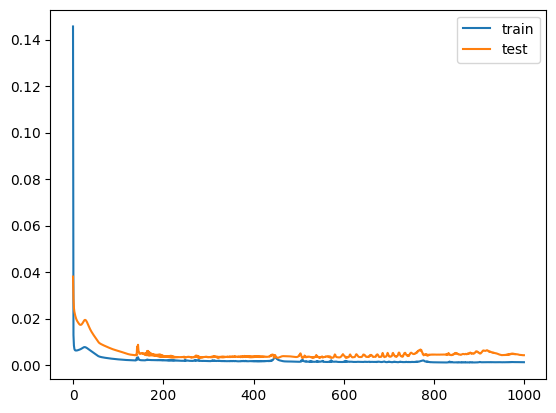

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step
---------------------------------------------------
LSTM evaluation for train set:
{'Mean Absolute Error (MAE)': 0.03780179841344706, 'Mean Squared Error (MSE)': 0.002587076298232214, 'Root Mean Squared Error (RMSE)': 0.05086330994176661, 'Mean Absolute Percentage Error (MAPE)': 15350435840.521143, 'R2 Score': 0.8324530285971214}
LSTM evaluation for test set:
{'Mean Absolute Error (MAE)': 0.0758103713453956, 'Mean Squared Error (MSE)': 0.008420121325684744, 'Root Mean Squared Error (RMSE)': 0.09176121907257305, 'Mean Absolute Percentage Error (MAPE)': 0.13175086185563786, 'R2 Score': 0.18779424460486072}
---------------------------------------------------



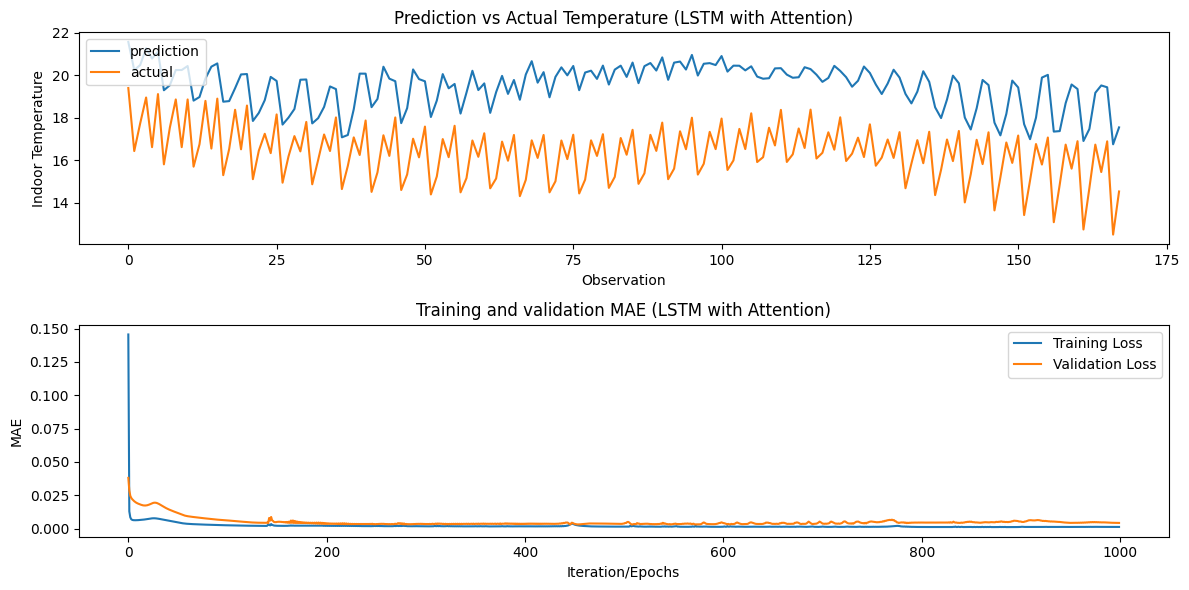

[[0.8324530285971214, 0.03780179841344706, 0.05086330994176661, 15350435840.521143, 0.18779424460486072, 0.0758103713453956, 0.09176121907257305, 0.13175086185563786]]


In [189]:
def LSTM_attention():
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    #By masking the zeros, the model can learn to ignore the missing values and focus on the valid data.
    masked = Masking(mask_value=0.)(inputs)
    lstm = LSTM(16, return_sequences=True)(masked)
    attention = dot([lstm, lstm], axes=[2, 2])
    # extracting weight for every observation in the history size!
    attention = Dense(6, activation='softmax')(attention)
    # assinging weight to lstm by dot product
    context = dot([attention, lstm], axes=[2, 1])
    flattened = Flatten()(context)
    output = Dense(1)(flattened)
    model = Model(inputs=inputs, outputs=output)
    return model

model = LSTM_attention()

optimizer = Adam()
model.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

model.summary()

# fit network
history = model.fit(X_train, y_train, epochs=1000, batch_size=400,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'LSTM with Attention')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 6, 16)          │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 6, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_2 (LSTM)                   │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,625 (18.07 KB)

 Trainable params: 4,625 (18.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
50/50 - 3s - 68ms/step - loss: 0.1566 - mae: 0.3824 - val_loss: 0.0476 - val_mae: 0.2785
Epoch 2/1000
50/50 - 0s - 4ms/step - loss: 0.0162 - mae: 0.1404 - val_loss: 0.0374 - val_mae: 0.2466
Epoch 3/1000
50/50 - 0s - 7ms/step - loss: 0.0132 - mae: 0.1268 - val_loss: 0.0366 - val_mae: 0.2447
Epoch 4/1000
50/50 - 0s - 5ms/step - loss: 0.0123 - mae: 0.1225 - val_loss: 0.0363 - val_mae: 0.2444
Epoch 5/1000
50/50 - 0s - 5ms/step - loss: 0.0116 - mae: 0.1194 - val_loss: 0.0359 - val_mae: 0.2432
Epoch 6/1000
50/50 - 0s - 4ms/step - loss: 0.0113 - mae: 0.1174 - val_loss: 0.0354 - val_mae: 0.2413
Epoch 7/1000
50/50 - 0s - 4ms/step - loss: 0.0108 - mae: 0.1155 - val_loss: 0.0352 - val_mae: 0.2412
Epoch 8/1000
50/50 - 0s - 7ms/step - loss: 0.0105 - mae: 0.1138 - val_loss: 0.0346 - val_mae: 0.2387
Epoch 9/1000
50/50 - 0s - 4ms/step - loss: 0.0102 - mae: 0.1123 - val_loss: 0.0344 - val_mae: 0.2382
Epoch 10/1000
50/50 - 0s - 4ms/step - loss: 0.0101 - mae: 0.1116 - val_loss: 0.0342 - val_

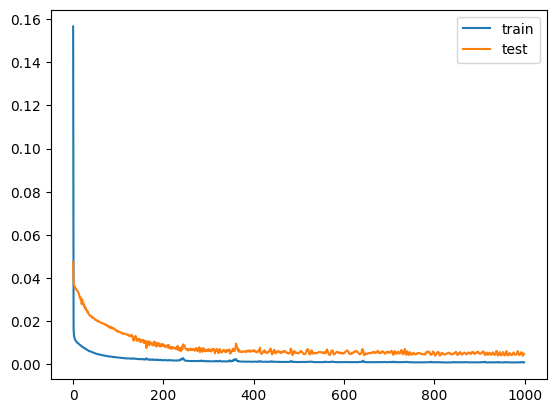

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step
---------------------------------------------------
LSTM evaluation for train set:
{'Mean Absolute Error (MAE)': 0.033413430687168684, 'Mean Squared Error (MSE)': 0.0020155047925645543, 'Root Mean Squared Error (RMSE)': 0.04489437372950596, 'Mean Absolute Percentage Error (MAPE)': 18195788034.616745, 'R2 Score': 0.8694697469599456}
LSTM evaluation for test set:
{'Mean Absolute Error (MAE)': 0.08171604024916651, 'Mean Squared Error (MSE)': 0.009870294972347276, 'Root Mean Squared Error (RMSE)': 0.0993493581878981, 'Mean Absolute Percentage Error (MAPE)': 0.14547264753487238, 'R2 Score': 0.18508443291711207}
---------------------------------------------------



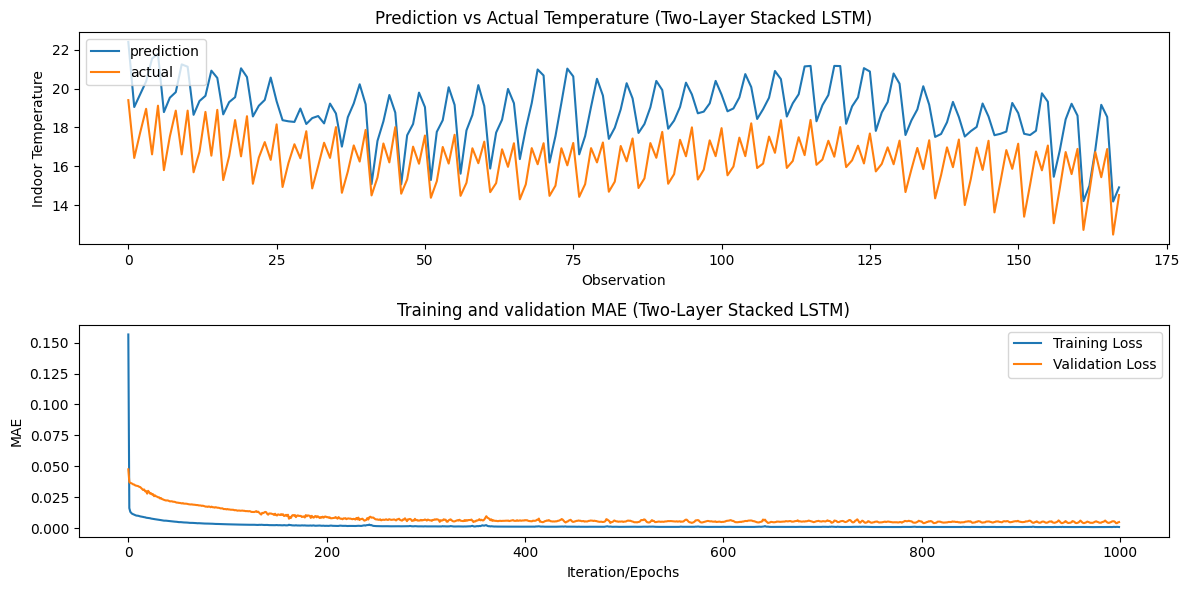

[[0.8694697469599456, 0.033413430687168684, 0.04489437372950596, 18195788034.616745, 0.18508443291711207, 0.08171604024916651, 0.0993493581878981, 0.14547264753487238]]


In [191]:
# design network
model = Sequential()
model.add(LSTM(units=16, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=True, activation='relu', name='LSTM_1'))
model.add(Dropout(0.1))
model.add(LSTM(units=16, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=False, activation='relu', name='LSTM_2'))
model.add(Dropout(0.1))
model.add(Dense(1, name='Output')) 

optimizer = Adam()
model.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

model.summary()

# fit network
history = model.fit(X_train, y_train, epochs=1000, batch_size=400,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'Two-Layer Stacked LSTM')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

Model: "functional_369"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_95      │ (None, 6, 22)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_1 (LSTM)       │ (None, 6, 16)     │      2,496 │ input_layer_95[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_69 (Dense)    │ (None, 6, 1)      │         17 │ LSTM_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_39          │ (None, 6)         │          0 │ dense_69[0][0]    │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 6)         │          0 │ flatten_39[0][0]  │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_5     │ (None, 16, 6)     │          0 │ activation_28[0]… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_5 (Permute) │ (None, 6, 16)     │          0 │ repeat_vector_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_5          │ (None, 6, 16)     │          0 │ LSTM_1[0][0],     │
│ (Multiply)          │                   │            │ permute_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_40          │ (None, 96)        │          0 │ multiply_5[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_79          │ (None, 96)        │          0 │ flatten_40[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 1)         │         97 │ dropout_79[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,610 (10.20 KB)

 Trainable params: 2,610 (10.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/400
197/197 - 14s - 73ms/step - loss: 0.0186 - mae: 0.1404 - val_loss: 0.0074 - val_mae: 0.0959
Epoch 2/400
197/197 - 0s - 2ms/step - loss: 0.0095 - mae: 0.1054 - val_loss: 0.0118 - val_mae: 0.1231
Epoch 3/400
197/197 - 0s - 1ms/step - loss: 0.0076 - mae: 0.0942 - val_loss: 0.0073 - val_mae: 0.0968
Epoch 4/400
197/197 - 0s - 1ms/step - loss: 0.0063 - mae: 0.0861 - val_loss: 0.0067 - val_mae: 0.0922
Epoch 5/400
197/197 - 0s - 2ms/step - loss: 0.0059 - mae: 0.0829 - val_loss: 0.0068 - val_mae: 0.0943
Epoch 6/400
197/197 - 0s - 1ms/step - loss: 0.0054 - mae: 0.0791 - val_loss: 0.0069 - val_mae: 0.0955
Epoch 7/400
197/197 - 0s - 1ms/step - loss: 0.0051 - mae: 0.0773 - val_loss: 0.0068 - val_mae: 0.0954
Epoch 8/400
197/197 - 0s - 1ms/step - loss: 0.0047 - mae: 0.0746 - val_loss: 0.0069 - val_mae: 0.0962
Epoch 9/400
197/197 - 0s - 1ms/step - loss: 0.0045 - mae: 0.0725 - val_loss: 0.0068 - val_mae: 0.0958
Epoch 10/400
197/197 - 0s - 1ms/step - loss: 0.0043 - mae: 0.0712 - val_loss: 0.

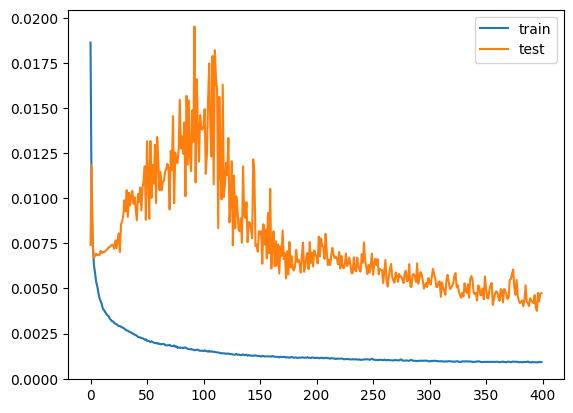

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
---------------------------------------------------
LSTM evaluation for train set:
{'Mean Absolute Error (MAE)': 0.03413769738853701, 'Mean Squared Error (MSE)': 0.0020548237659781805, 'Root Mean Squared Error (RMSE)': 0.04533016397475505, 'Mean Absolute Percentage Error (MAPE)': 17800915290.959175, 'R2 Score': 0.8669233300186961}
LSTM evaluation for test set:
{'Mean Absolute Error (MAE)': 0.07840369575323965, 'Mean Squared Error (MSE)': 0.009479666119336294, 'Root Mean Squared Error (RMSE)': 0.09736357696457282, 'Mean Absolute Percentage Error (MAPE)': 0.1540285662691491, 'R2 Score': 0.2909519308142833}
---------------------------------------------------



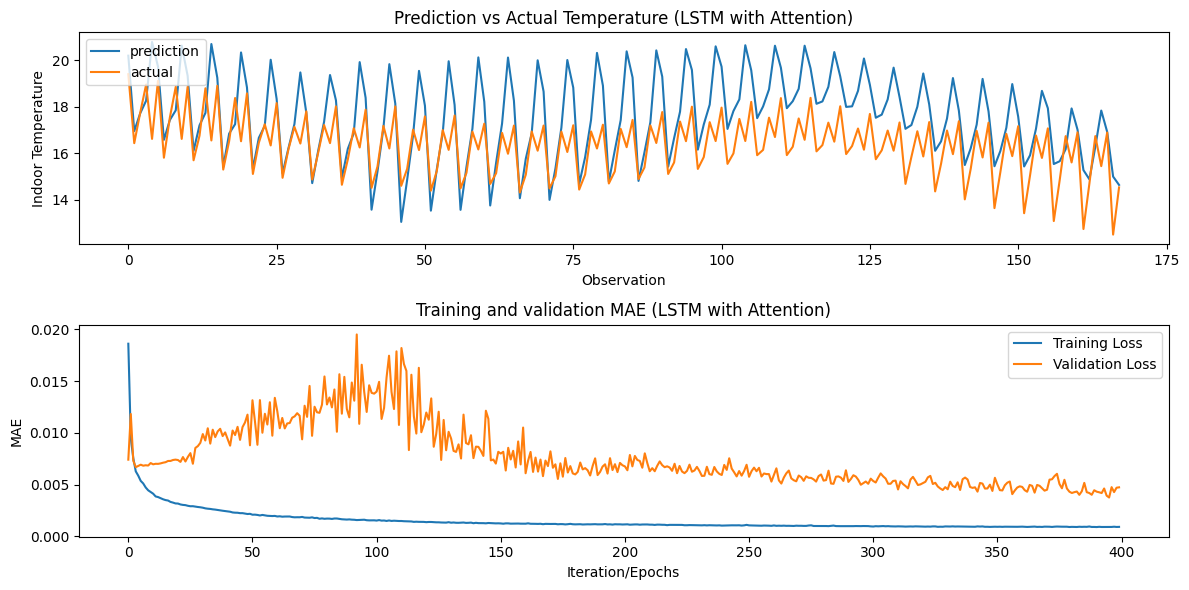

[[0.8669233300186961, 0.03413769738853701, 0.04533016397475505, 17800915290.959175, 0.2909519308142833, 0.07840369575323965, 0.09736357696457282, 0.1540285662691491]]


In [204]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input, Attention, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

def attention_3d_block(inputs):
    # Compute the attention scores
    attention = Dense(1, activation='relu')(inputs)
    attention = tf.keras.layers.Flatten()(attention)
    attention = tf.keras.layers.Activation('softmax')(attention)
    attention = tf.keras.layers.RepeatVector(inputs.shape[-1])(attention)
    attention = tf.keras.layers.Permute([2, 1])(attention)
    
    # Apply the attention scores to the inputs
    output_attention = tf.keras.layers.Multiply()([inputs, attention])
    return output_attention

def build_model_with_attention(input_shape):
    input_layer = Input(shape=input_shape)
    
    lstm_out = LSTM(units=16, return_sequences=True, activation='relu', name='LSTM_1')(input_layer)
    
    attention_out = attention_3d_block(lstm_out)
    
    attention_out = tf.keras.layers.Flatten()(attention_out)
    
    dropout = Dropout(0.1)(attention_out)
    
    output_layer = Dense(1, name='Output')(dropout)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model

# Build and compile the model
model = build_model_with_attention((X_train.shape[1], X_train.shape[2]))
optimizer = Adam()
model.compile(loss='huber', optimizer=optimizer, metrics=['mae'])
model.summary()


# fit network
history = model.fit(X_train, y_train, epochs=400, batch_size=100,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'LSTM with Attention')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 16)             │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,513 (9.82 KB)

 Trainable params: 2,513 (9.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
50/50 - 3s - 67ms/step - loss: 2.6463 - mae: 1.1564 - val_loss: 1.8934 - val_mae: 0.6444
Epoch 2/1000
50/50 - 0s - 3ms/step - loss: 1.4903 - mae: 0.4035 - val_loss: 1.1834 - val_mae: 0.2821
Epoch 3/1000
50/50 - 0s - 2ms/step - loss: 0.9846 - mae: 0.2506 - val_loss: 0.7919 - val_mae: 0.2328
Epoch 4/1000
50/50 - 0s - 2ms/step - loss: 0.6538 - mae: 0.2005 - val_loss: 0.5185 - val_mae: 0.1993
Epoch 5/1000
50/50 - 0s - 2ms/step - loss: 0.4296 - mae: 0.1631 - val_loss: 0.3535 - val_mae: 0.1837
Epoch 6/1000
50/50 - 0s - 2ms/step - loss: 0.3053 - mae: 0.1421 - val_loss: 0.2754 - val_mae: 0.1771
Epoch 7/1000
50/50 - 0s - 2ms/step - loss: 0.2485 - mae: 0.1318 - val_loss: 0.2365 - val_mae: 0.1839
Epoch 8/1000
50/50 - 0s - 2ms/step - loss: 0.2121 - mae: 0.1270 - val_loss: 0.2044 - val_mae: 0.1783
Epoch 9/1000
50/50 - 0s - 2ms/step - loss: 0.1843 - mae: 0.1229 - val_loss: 0.1810 - val_mae: 0.1782
Epoch 10/1000
50/50 - 0s - 3ms/step - loss: 0.1643 - mae: 0.1243 - val_loss: 0.1635 - val_

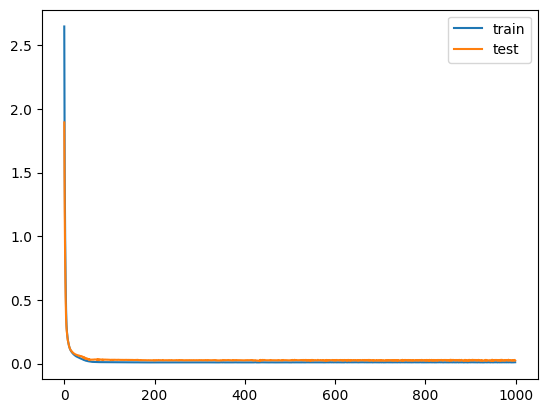

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step
---------------------------------------------------
LSTM evaluation for train set:
{'Mean Absolute Error (MAE)': 0.09571297874607046, 'Mean Squared Error (MSE)': 0.014794703001302098, 'Root Mean Squared Error (RMSE)': 0.12163347812712624, 'Mean Absolute Percentage Error (MAPE)': 100133398059.89053, 'R2 Score': 0.04184979686642831}
LSTM evaluation for test set:
{'Mean Absolute Error (MAE)': 0.1851082411464237, 'Mean Squared Error (MSE)': 0.04391077303869717, 'Root Mean Squared Error (RMSE)': 0.20954897527474853, 'Mean Absolute Percentage Error (MAPE)': 0.4229582921817012, 'R2 Score': -209.8958338816812}
---------------------------------------------------



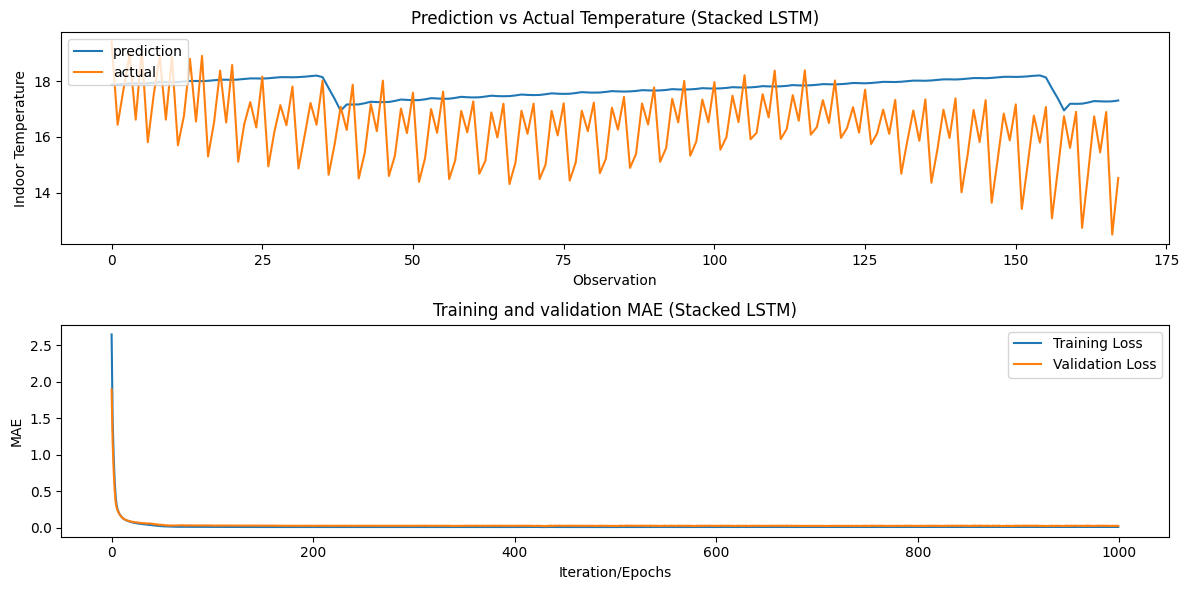

[[0.04184979686642831, 0.09571297874607046, 0.12163347812712624, 100133398059.89053, -209.8958338816812, 0.1851082411464237, 0.20954897527474853, 0.4229582921817012]]


In [207]:
from tensorflow.keras.regularizers import l2
from keras.regularizers import L1L2

# design network
model = Sequential()
model.add(LSTM(units=16, input_shape=(X_train.shape[1], X_train.shape[2]) ,activation='relu', name='LSTM_1', kernel_regularizer=L1L2(l1=0.01, l2=0.01)))
model.add(Dropout(0.1))
model.add(Dense(1, name='Output')) 

optimizer = Adam()
model.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

model.summary()

# fit network
history = model.fit(X_train, y_train, epochs=1000, batch_size=400,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'Stacked LSTM')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                   │ (None, 16)             │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,513 (9.82 KB)

 Trainable params: 2,513 (9.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
50/50 - 3s - 68ms/step - loss: 7.6134 - mae: 6.4297 - val_loss: 3.5087 - val_mae: 2.5049
Epoch 2/1000
50/50 - 0s - 2ms/step - loss: 2.0874 - mae: 1.2113 - val_loss: 1.3566 - val_mae: 0.5793
Epoch 3/1000
50/50 - 0s - 2ms/step - loss: 1.2713 - mae: 0.6322 - val_loss: 0.9131 - val_mae: 0.3390
Epoch 4/1000
50/50 - 0s - 2ms/step - loss: 0.8631 - mae: 0.4115 - val_loss: 0.6526 - val_mae: 0.2354
Epoch 5/1000
50/50 - 0s - 2ms/step - loss: 0.5881 - mae: 0.2211 - val_loss: 0.5139 - val_mae: 0.2128
Epoch 6/1000
50/50 - 0s - 2ms/step - loss: 0.4742 - mae: 0.1736 - val_loss: 0.4500 - val_mae: 0.2221
Epoch 7/1000
50/50 - 0s - 2ms/step - loss: 0.4165 - mae: 0.1615 - val_loss: 0.4073 - val_mae: 0.2307
Epoch 8/1000
50/50 - 0s - 2ms/step - loss: 0.3748 - mae: 0.1579 - val_loss: 0.3709 - val_mae: 0.2313
Epoch 9/1000
50/50 - 0s - 3ms/step - loss: 0.3404 - mae: 0.1543 - val_loss: 0.3396 - val_mae: 0.2314
Epoch 10/1000
50/50 - 0s - 2ms/step - loss: 0.3105 - mae: 0.1529 - val_loss: 0.3140 - val_

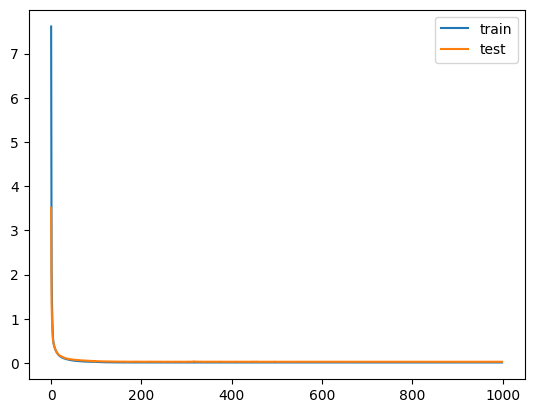

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step
---------------------------------------------------
LSTM evaluation for train set:
{'Mean Absolute Error (MAE)': 0.09786536205446433, 'Mean Squared Error (MSE)': 0.015537413985308406, 'Root Mean Squared Error (RMSE)': 0.12464916359650556, 'Mean Absolute Percentage Error (MAPE)': 97685104933.70415, 'R2 Score': -0.006250437395290076}
LSTM evaluation for test set:
{'Mean Absolute Error (MAE)': 0.19483793222473347, 'Mean Squared Error (MSE)': 0.048515325299380276, 'Root Mean Squared Error (RMSE)': 0.22026194700714938, 'Mean Absolute Percentage Error (MAPE)': 0.4572222737895046, 'R2 Score': -110013.13757166329}
---------------------------------------------------



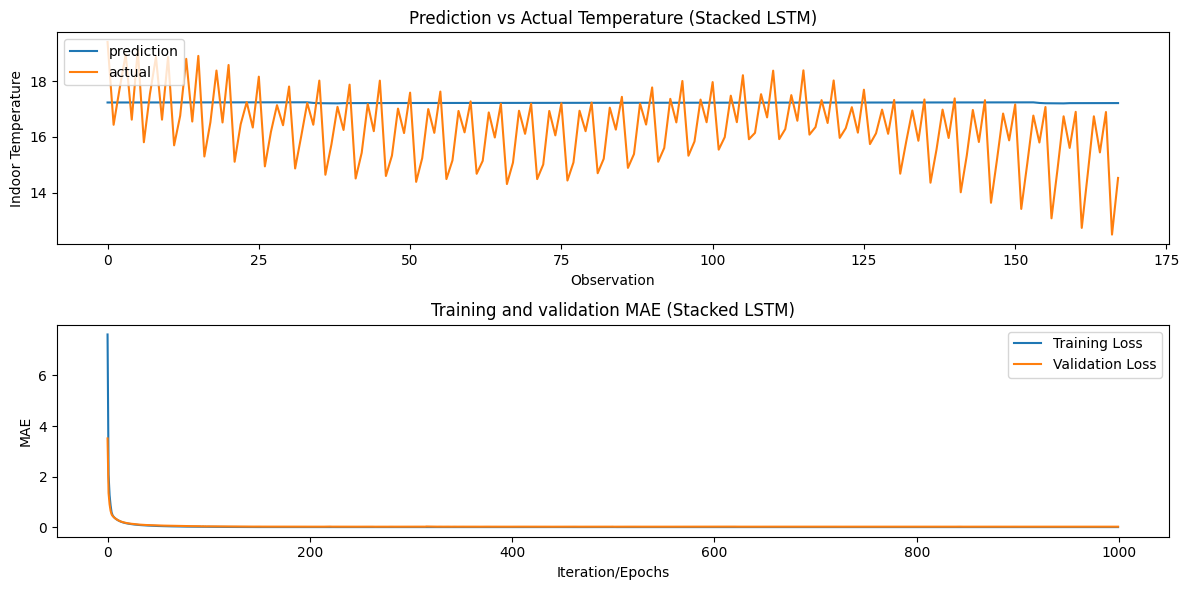

[[-0.006250437395290076, 0.09786536205446433, 0.12464916359650556, 97685104933.70415, -110013.13757166329, 0.19483793222473347, 0.22026194700714938, 0.4572222737895046]]


In [208]:
from tensorflow.keras.regularizers import l2
from keras.regularizers import L1L2

# design network
model = Sequential()
model.add(LSTM(units=16, input_shape=(X_train.shape[1], X_train.shape[2]) ,activation='relu', name='LSTM_1', kernel_regularizer=L1L2(l1=0.01, l2=0.00)))
model.add(Dropout(0.1))
model.add(Dense(1, name='Output')) 

optimizer = Adam()
model.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

model.summary()

# fit network
history = model.fit(X_train, y_train, epochs=1000, batch_size=400,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'Stacked LSTM')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

Trial 90 Complete [00h 00m 22s]
val_mae: 0.08217508345842361

Best val_mae So Far: 0.027909215539693832
Total elapsed time: 00h 28m 35s
Best hyperparameters:  {'units': 240, 'return_sequences': False, 'batch_normalization': True, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0067'}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 240)            │       252,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 240)            │           960 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 240)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           241 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253,681 (990.94 KB)

 Trainable params: 253,201 (989.07 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/1000
50/50 - 4s - 80ms/step - loss: 0.0044 - mae: 0.0750 - val_loss: 0.0027 - val_mae: 0.0585 - learning_rate: 0.0010
Epoch 2/1000
50/50 - 1s - 20ms/step - loss: 0.0056 - mae: 0.0848 - val_loss: 0.0024 - val_mae: 0.0523 - learning_rate: 0.0010
Epoch 3/1000
50/50 - 1s - 19ms/step - loss: 0.0058 - mae: 0.0853 - val_loss: 0.0028 - val_mae: 0.0551 - learning_rate: 0.0010
Epoch 4/1000
50/50 - 1s - 24ms/step - loss: 0.0058 - mae: 0.0863 - val_loss: 0.0044 - val_mae: 0.0685 - learning_rate: 0.0010
Epoch 5/1000
50/50 - 2s - 36ms/step - loss: 0.0060 - mae: 0.0869 - val_loss: 0.0060 - val_mae: 0.0899 - learning_rate: 0.0010
Epoch 6/1000
50/50 - 1s - 25ms/step - loss: 0.0060 - mae: 0.0867 - val_loss: 0.0064 - val_mae: 0.0930 - learning_rate: 0.0010
Epoch 7/1000
50/50 - 2s - 34ms/step - loss: 0.0060 - mae: 0.0869 - val_loss: 0.0078 - val_mae: 0.1062 - learning_rate: 0.0010
Epoch 8/1000
50/50 - 1s - 29ms/step - loss: 0.0060 - mae: 0.0866 - val_loss: 0.0091 - val_mae: 0.1180 - learning_rate:

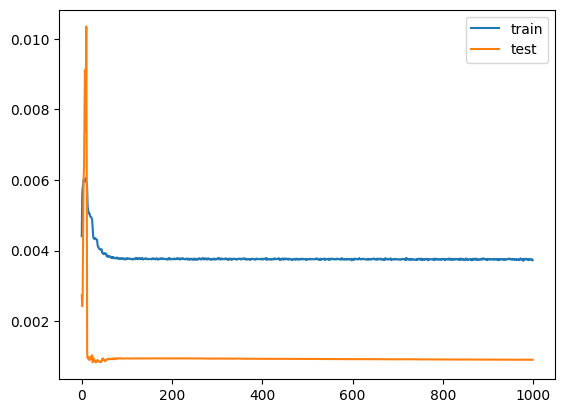

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
---------------------------------------------------
LSTM evaluation for train set:
{'Mean Absolute Error (MAE)': 0.09786536205446433, 'Mean Squared Error (MSE)': 0.015537413985308406, 'Root Mean Squared Error (RMSE)': 0.12464916359650556, 'Mean Absolute Percentage Error (MAPE)': 97685104933.70415, 'R2 Score': -0.006250437395290076}
LSTM evaluation for test set:
{'Mean Absolute Error (MAE)': 0.19483793222473347, 'Mean Squared Error (MSE)': 0.048515325299380276, 'Root Mean Squared Error (RMSE)': 0.22026194700714938, 'Mean Absolute Percentage Error (MAPE)': 0.4572222737895046, 'R2 Score': -110013.13757166329}
---------------------------------------------------



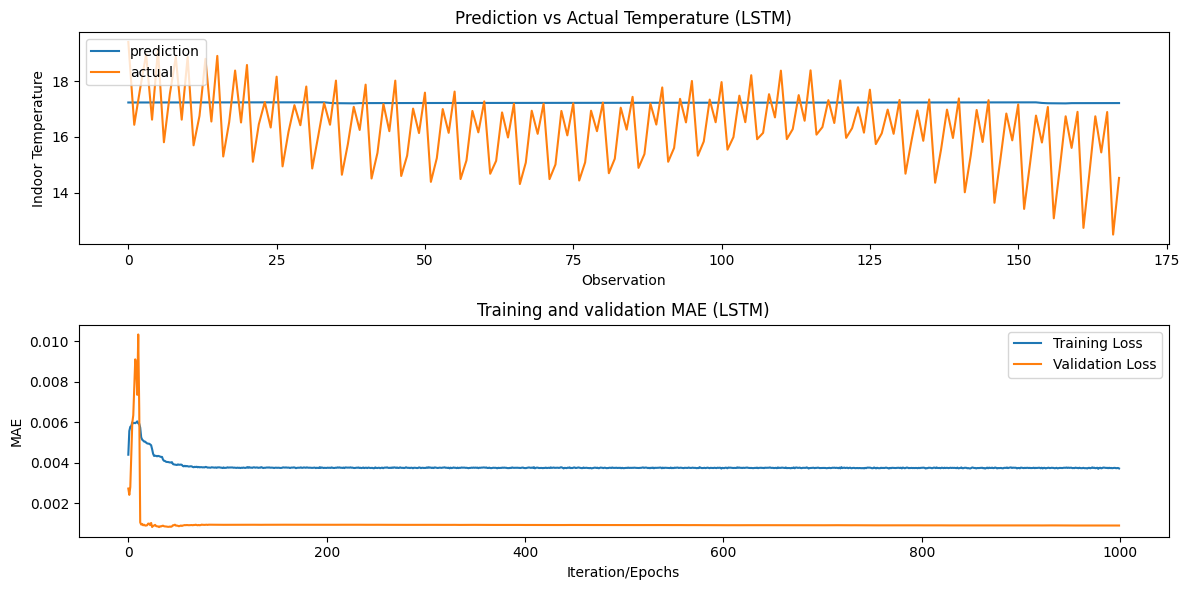

[[-0.006250437395290076, 0.09786536205446433, 0.12464916359650556, 97685104933.70415, -110013.13757166329, 0.19483793222473347, 0.22026194700714938, 0.4572222737895046]]


In [210]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Define the model creation function
def build_model(hp):
    model = Sequential()
    
    model.add(LSTM(units=hp.Int('units', min_value=16, max_value=256, step=32),
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   return_sequences=hp.Boolean('return_sequences'),
                   activation='relu'))
    
    if hp.Boolean('batch_normalization'):
        model.add(BatchNormalization())
    
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))
    
    model.add(Dense(units=1))
    
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='huber',
        metrics=['mae']
    )
    
    return model

# Set up the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_mae',
    max_epochs=50,
    factor=3,
    directory='kt_dir',
    project_name='lstm_tuning_2'
)

# EarlyStopping callback
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, restore_best_weights=True)

# Run the search
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopper])

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters: ", best_hyperparameters.values)
best_model.summary()

# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

# Fit the best model on the full training data
history = best_model.fit(X_train, y_train, epochs=1000, batch_size=400, validation_data=(X_val, y_val), verbose=2, shuffle=False, callbacks=[reduce_lr])

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'LSTM')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_21 (Conv1D)              │ (None, 4, 6)           │           402 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_30 (Flatten)            │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,235 (4.82 KB)

 Trainable params: 1,235 (4.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step - loss: 0.8524 - val_loss: 0.0751
Epoch 2/100
393/393 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 0.0958 - val_loss: 0.0689


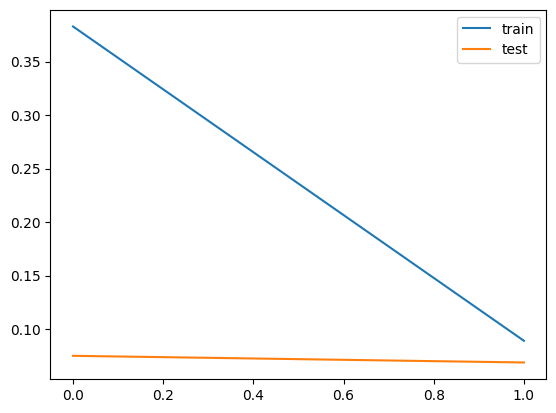

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 227us/step
---------------------------------------------------
CNN evaluation for train set:
{'Mean Absolute Error (MAE)': 0.07058197712402278, 'Mean Squared Error (MSE)': 0.008201239138889909, 'Root Mean Squared Error (RMSE)': 0.09056069312284391, 'Mean Absolute Percentage Error (MAPE)': 61094672579.46273, 'R2 Score': 0.4688626769876507}
CNN evaluation for test set:
{'Mean Absolute Error (MAE)': 0.16037916895505025, 'Mean Squared Error (MSE)': 0.03545389328526768, 'Root Mean Squared Error (RMSE)': 0.18829204254367118, 'Mean Absolute Percentage Error (MAPE)': 0.3903668105206364, 'R2 Score': -2.854548264157855}
---------------------------------------------------



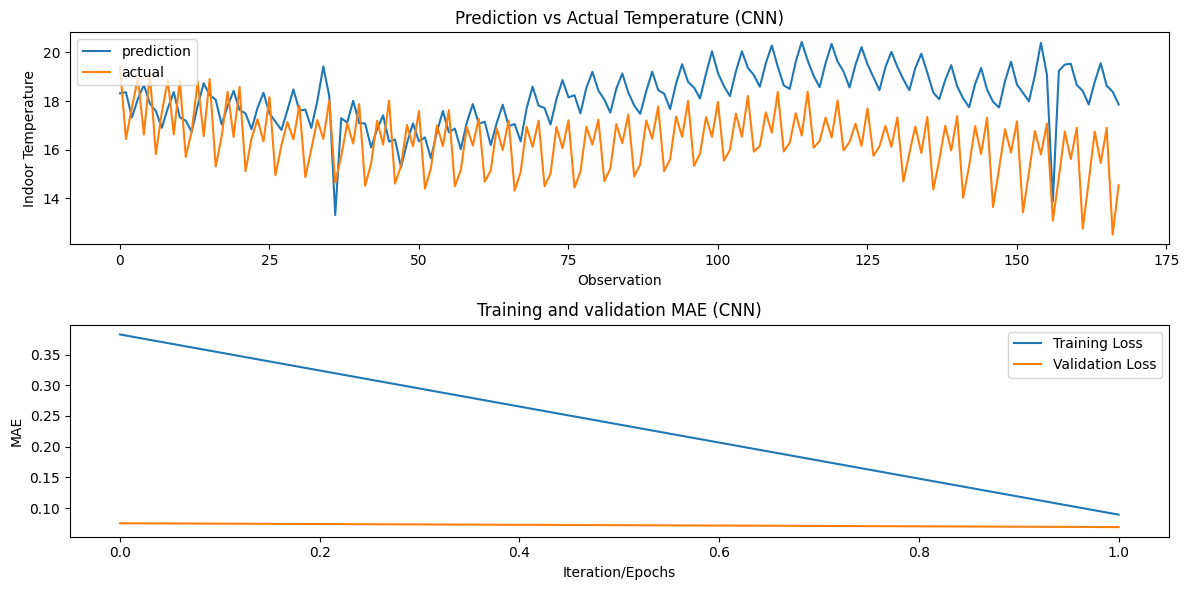

[[0.4688626769876507, 0.07058197712402278, 0.09056069312284391, 61094672579.46273, -2.854548264157855, 0.16037916895505025, 0.18829204254367118, 0.3903668105206364]]


In [197]:
model = Sequential()
model.add(Conv1D(filters=6, kernel_size=3, activation='relu', input_shape=X_train.shape[-2:]))
model.add(Flatten())
model.add(Dense(32, activation='relu')) #'relu', 'tanh', 'sigmoid', 'linear', 'swish'
model.add(Dropout(0.1))
model.add(Dense(1))
    
cnn_optimizer = Adam() #Adam, SGD, 'RMSprop
model.compile(optimizer = cnn_optimizer , loss = 'mean_absolute_error')
model.summary()

epoch= 100
batch_size= 50
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = epoch, 
                   batch_size = batch_size, callbacks=[callback])

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'CNN evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'CNN evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'CNN')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

In [192]:
# design network
model = Sequential()
model.add(LSTM(units=16, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=True, activation='relu', name='LSTM_1'))
model.add(Dropout(0.1))
model.add(LSTM(units=16, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=True, activation='relu', name='LSTM_2'))
model.add(Dropout(0.1))
model.add(LSTM(units=16, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=False, activation='relu', name='LSTM_2'))
model.add(Dropout(0.1))
model.add(Dense(1, name='Output')) 

optimizer = Adam()
model.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

model.summary()

# fit network
history = model.fit(X_train, y_train, epochs=1000, batch_size=400,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'Three Layer Stacked LSTM')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: All layers added to a Sequential model should have unique names. Name 'LSTM_2' is already the name of a layer in this model. Update the `name` argument to pass a unique name.

In [ ]:
# design network
model = Sequential()
model.add(LSTM(units=16, input_shape=(X_train.shape[1], X_train.shape[2]) , return_sequences=False, activation='relu', name='LSTM_1'))
model.add(Dropout(0.3))
model.add(Dense(1, name='Output')) 

optimizer = Adam()
model.compile(loss='Huber',optimizer=optimizer, metrics=['mae'])

model.summary()

# fit network
history = model.fit(X_train, y_train, epochs=2000, batch_size=400,validation_data=(X_test, y_test), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'Basic NN')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

In [151]:
# make a prediction
test_Y_predicted = model.predict(X_test)
test_X = X_test.reshape((X_test.shape[0], n_hours*n_features))


print(test_Y_predicted)
print(y_test)

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step
[[0.5859308 ]
 [0.4701435 ]
 [0.5351298 ]
 ...
 [0.54234385]
 [0.5982512 ]
 [0.71148896]]
[[0.50163075]
 [0.39789273]
 [0.44344787]
 ...
 [0.53196541]
 [0.59087327]
 [0.55775578]]


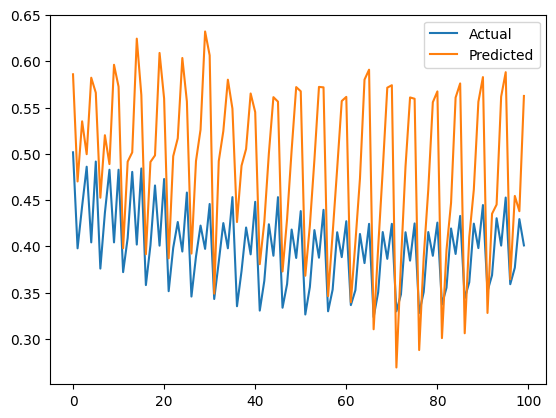

In [152]:
plt.plot(y_test[:100],label="Actual")
plt.plot(test_Y_predicted[:100],label="Predicted")
plt.legend()

In [155]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

def base_model_lstm():
    model = Sequential()
    model.add(LSTM(units = 16, return_sequences = True, activation="relu", input_shape = X_train.shape[-2:]))
    model.add(Flatten())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    return model

lstm_model = base_model_lstm()
lstm_optimizer = Adam()
lstm_model.compile(optimizer = lstm_optimizer , loss = 'mean_absolute_error',metrics=[tf.keras.metrics.RootMeanSquaredError()])
lstm_model.summary()

history = lstm_model.fit(X_train, y_train, validation_data = (X_val, y_val),  epochs=400, batch_size=512, callbacks=[callback])



/Users/zainabakhtar/anaconda3/envs/thermo_dl_project/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                  │ (None, 6, 16)          │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,769 (34.25 KB)

 Trainable params: 8,769 (34.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/400
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7118 - root_mean_squared_error: 2.3837 - val_loss: 0.1642 - val_root_mean_squared_error: 0.1976
Epoch 2/400
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4143 - root_mean_squared_error: 0.6029 - val_loss: 0.0961 - val_root_mean_squared_error: 0.1181
Epoch 3/400
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1723 - root_mean_squared_error: 0.2402 - val_loss: 0.0664 - val_root_mean_squared_error: 0.0832
Epoch 4/400
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0980 - root_mean_squared_error: 0.1260 - val_loss: 0.0614 - val_root_mean_squared_error: 0.0785
Epoch 5/400
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0857 - root_mean_squared_error: 0.1088 - val_loss: 0.0692 - val_root_mean_squared_error: 0.0886
Epoch 6/400
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0807 - root_mean_squared_error: 0.1029 - val_loss: 0.0830 - val_root_mean_squared_error: 0.1037


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step
613/613 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
---------------------------------------------------
LSTM evaluation for train set:
{'Mean Absolute Error (MAE)': 0.06277409585294255, 'Mean Squared Error (MSE)': 0.006500809432896821, 'Root Mean Squared Error (RMSE)': 0.0806275972164421, 'Mean Absolute Percentage Error (MAPE)': 62966823072.364105, 'R2 Score': 0.5789877040374161}
LSTM evaluation for test set:
{'Mean Absolute Error (MAE)': 0.10850275348241999, 'Mean Squared Error (MSE)': 0.017608858154916533, 'Root Mean Squared Error (RMSE)': 0.13269837284200786, 'Mean Absolute Percentage Error (MAPE)': 0.22111092648845565, 'R2 Score': -0.28762120218019316}
---------------------------------------------------



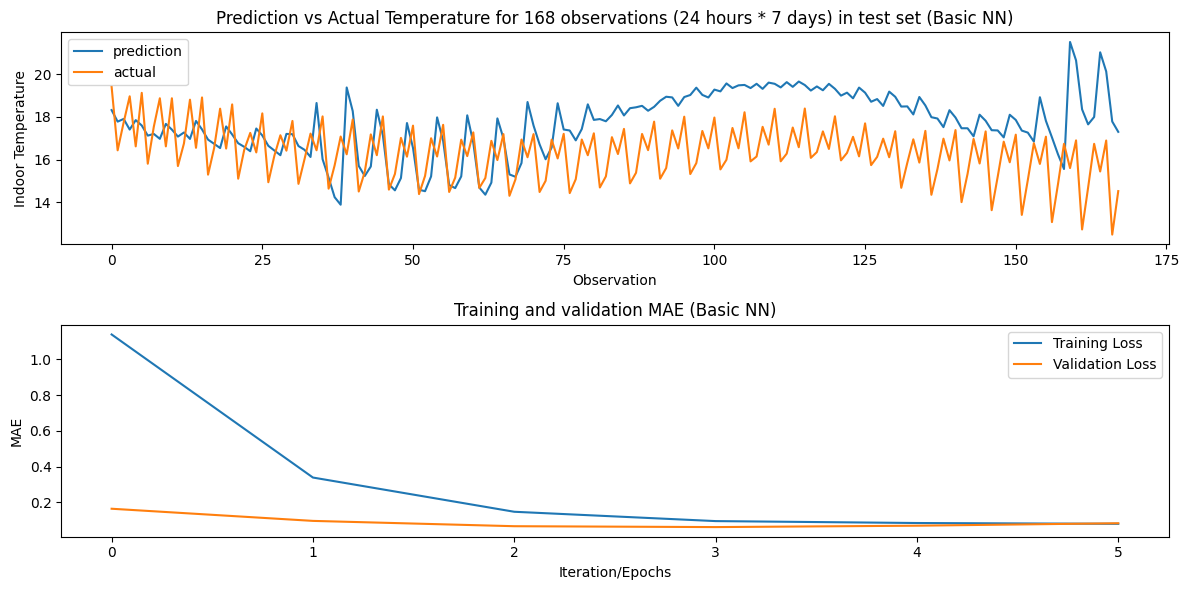

[[0.5789877040374161, 0.06277409585294255, 0.0806275972164421, 62966823072.364105, -0.28762120218019316, 0.10850275348241999, 0.13269837284200786, 0.22111092648845565]]


In [156]:
y_pred = lstm_model.predict(X_test)
y_train_pred = lstm_model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'Basic NN')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)


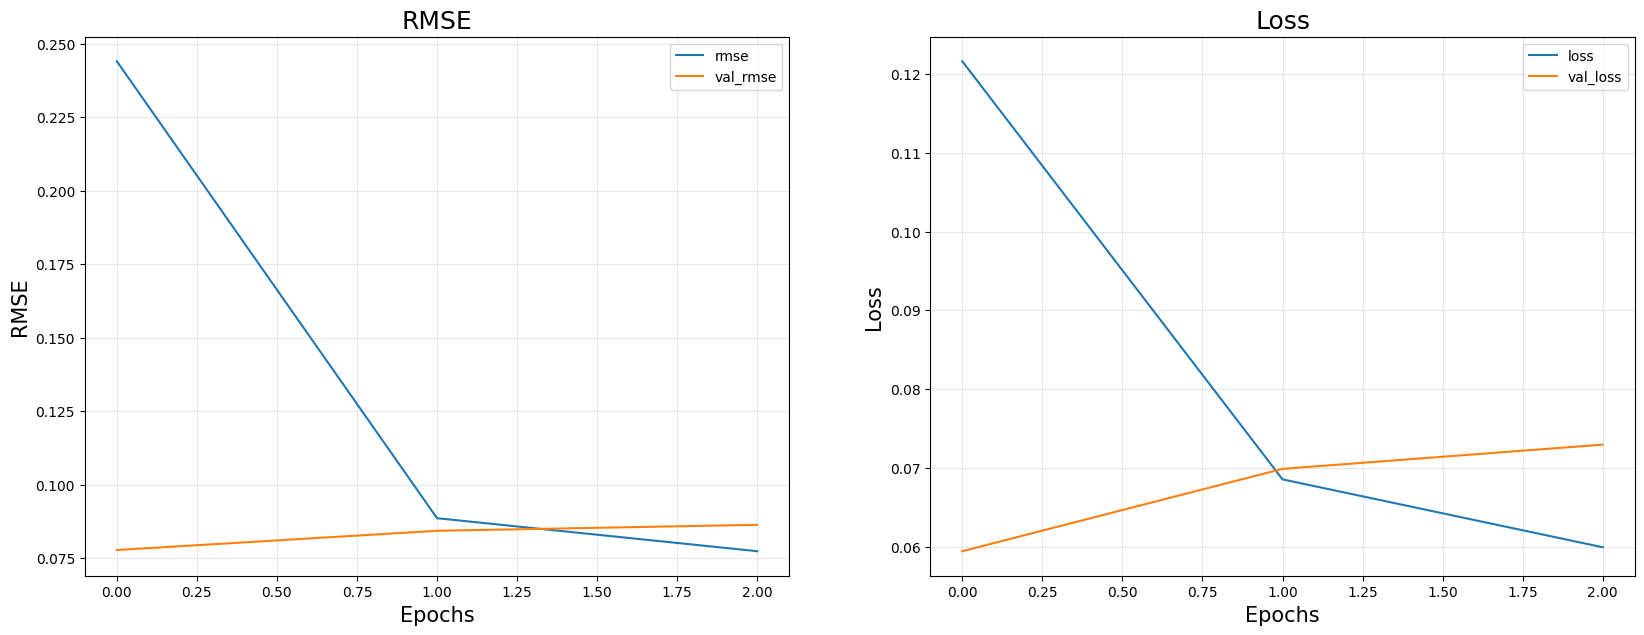

In [78]:
fig = plt.figure(figsize=(20,7))
fig.add_subplot(121)

# Accuracy
plt.plot(history.epoch, history.history['root_mean_squared_error'], label = "rmse")
plt.plot(history.epoch, history.history['val_root_mean_squared_error'], label = "val_rmse")

plt.title("RMSE", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("RMSE", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()


#Adding Subplot 1 (For Loss)
fig.add_subplot(122)

plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")

plt.title("Loss", fontsize=18)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [57]:
scaler_y =joblib.load("./tmp_lstm/assets/min_max_scaler_y.joblib",mmap_mode=None)

y_pred = lstm_model.predict(test_X)
y_train_pred = lstm_model.predict(X_train)
y_test_inv = scaler_y.inverse_transform(Y_test)

results = []

print('---------------------------------------------------')
print(f'LSTM evaluation for train set:')
train_report = regression_report(Y_train, y_train_pred)
print(train_report)
print(f'LSTM evaluation for test set:')
test_report = regression_report(y_pred,Y_test)
print(test_report)
print('---------------------------------------------------')
y_pred_actual = scaler_y.inverse_transform(y_pred)
print('')
plot_results(y_pred_actual, y_test_inv, history,'LSTM')

results.append([
        train_report['R2 Score'], train_report['Mean Absolute Error (MAE)'], train_report['Root Mean Squared Error (RMSE)'], train_report['Mean Absolute Percentage Error (MAPE)'],
        test_report['R2 Score'], test_report['Mean Absolute Error (MAE)'], test_report['Root Mean Squared Error (RMSE)'], test_report['Mean Absolute Percentage Error (MAPE)']
    ])

print(results)

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [35]:
# design network
model = Sequential()
model.add(LSTM(30, input_shape=(train_X.shape[1], train_X.shape[2])))    # input_shape=(no. of i/p, dimension), result=(1,50)
# test
model.add(Dense(256,name='FC1'))  #256
model.add(Activation('relu'))
model.add(Dropout(0.2))
# end
model.add(Dense(1,name='out_layer'))
model.compile(loss='mean_squared_error',optimizer='adam', metrics=['mean_squared_error'])

In [36]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 30)             │         6,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC1 (Dense)                     │ (None, 256)            │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,553 (56.85 KB)

 Trainable params: 14,553 (56.85 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# fit network
history = model.fit(train_X, train_Y, epochs=100, batch_size=128, validation_data=(test_X, test_Y), verbose=2, shuffle=False)  #, verbose=2, shuffle=False

Epoch 1/100
176/176 - 1s - 8ms/step - loss: 0.0332 - mean_squared_error: 0.0332 - val_loss: 0.0955 - val_mean_squared_error: 0.0955
Epoch 2/100
176/176 - 0s - 2ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0875 - val_mean_squared_error: 0.0875
Epoch 3/100
176/176 - 0s - 2ms/step - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0841 - val_mean_squared_error: 0.0841
Epoch 4/100
176/176 - 0s - 2ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - val_loss: 0.0856 - val_mean_squared_error: 0.0856
Epoch 5/100
176/176 - 0s - 2ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - val_loss: 0.0794 - val_mean_squared_error: 0.0794
Epoch 6/100
176/176 - 0s - 2ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0886 - val_mean_squared_error: 0.0886
Epoch 7/100
176/176 - 0s - 2ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - val_loss: 0.0854 - val_mean_squared_error: 0.0854
Epoch 8/100
176/176 - 0s - 2ms/step - loss: 0.0102 - mean_squared_error: 0.0

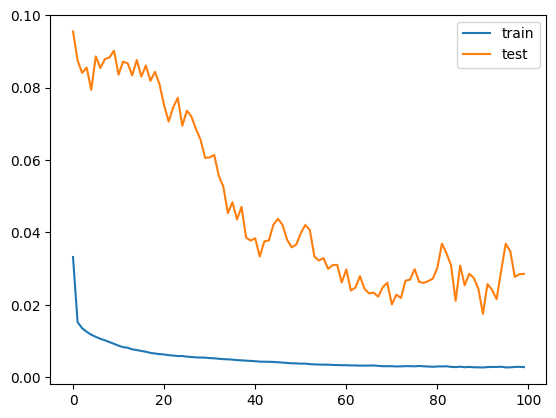

In [39]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [40]:
# make a prediction
test_Y_predicted = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step


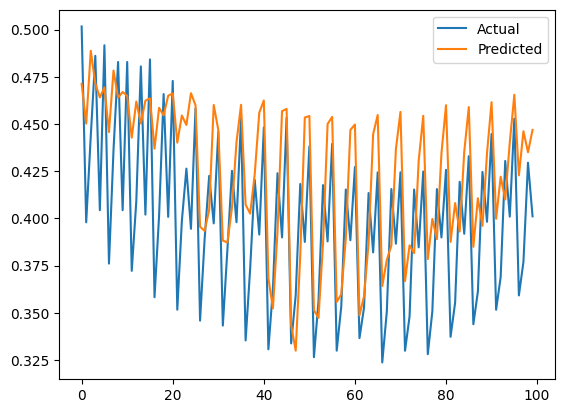

In [41]:
pyplot.plot(test_Y[:100],label="Actual")
pyplot.plot(test_Y_predicted[:100],label="Predicted")
pyplot.legend()